# **E-Commerce Customer Behavior & Sales Analysis**

## 1. **Project Overview**

This project analyzes a comprehensive e-commerce sales data from turkish online retail platform. The goal is to understand customer behavior, purchasing patterns and market performance to support data driven decision.

The project identifies distinct customer segments, evaluates sales trends across product categories, and uncovers key factors that influence spending, satisfaction, and repeat purchases.

---

## 2. **Data Overview**

In this section, we explore the structure and characteristics of the e-commerce dataset to understand its variables and data quality before performing analysis or modeling.

Key Tasks:

- Examine the dataset dimensions and column types  
- Display sample records to understand the format  
- Review summary statistics (mean, median, min, max)  
- Check for missing values, data inconsistencies and duplicated values


In [122]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import sqlite3
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import warnings
warnings.filterwarnings('ignore')

In [123]:
path = kagglehub.dataset_download("umuttuygurr/e-commerce-customer-behavior-and-sales-analysis-tr")
print(f"data path: {path}")

data path: C:\Users\USER\.cache\kagglehub\datasets\umuttuygurr\e-commerce-customer-behavior-and-sales-analysis-tr\versions\2


In [124]:
print(os.listdir(path))

['DATASET_README.md', 'ecommerce_customer_behavior_dataset.csv', 'ecommerce_customer_behavior_dataset_v2.csv', 'ecommerce_dataset_readme_v_2.md']


In [183]:
df = pd.read_csv(os.path.join(path, 'ecommerce_customer_behavior_dataset.csv'))
df.head()

Order_ID Customer_ID        Date  Age  Gender      City Product_Category  \
0  ORD_001337  CUST_01337  2023-01-01   27  Female     Bursa             Toys   
1  ORD_004885  CUST_04885  2023-01-01   42    Male     Konya             Toys   
2  ORD_004507  CUST_04507  2023-01-01   43  Female    Ankara             Food   
3  ORD_000645  CUST_00645  2023-01-01   32    Male  Istanbul      Electronics   
4  ORD_000690  CUST_00690  2023-01-01   40  Female  Istanbul           Sports   

   Unit_Price  Quantity  Discount_Amount  Total_Amount    Payment_Method  \
0       54.28         1             0.00         54.28        Debit Card   
1      244.90         1             0.00        244.90       Credit Card   
2       48.15         5             0.00        240.75       Credit Card   
3      804.06         1           229.28        574.78       Credit Card   
4      755.61         5             0.00       3778.05  Cash on Delivery   

  Device_Type  Session_Duration_Minutes  Pages_Viewed  Is_Returning_Customer  \
0      Mobile                         4            14                   True   
1      Mobile                        11             3                   True   
2      Mobile                         7             8                   True   
3      Mobile                         8            10                  False   
4     Desktop                        21            10                   True   

   Delivery_Time_Days  Customer_Rating  
0                   8                5  
1                   3                3  
2                   5                2  
3                   1                4  
4                   7                4

## **Data Overview Function**

This function provides a quick, structured summary of any given dataset. It helps the analyst understand the **shape, structure, data types, missing values, duplicates, and key statistics** before starting deeper analysis.  

In [126]:
def data_overview(df):
    print("Data Overview")
    print("="*60)
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print("="*60)

    print("\nColumn Names:")
    print(df.columns.tolist())
    print("="*60)

    print("\nData Types:")
    print(df.dtypes)
    print("="*60)

    print("\nMissing Values:")
    print(df.isnull().sum())
    print("="*60)

    print("\nDuplicate Rows:")
    print(df.duplicated().sum())
    print("="*60)

    print("\nUnique Values per Column:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()}")
    
    print("\nStatistical Summary:")
    print(df.describe())

### Input

| Parameter | Type | Description |
|------------|------|-------------|
| `df` | `pandas.DataFrame` | The dataset to be analyzed. Should contain both numerical and categorical columns. |

#### Output
- Prints a formatted summary to the console, including:

  - Number of rows and columns.  

  - List of column names. 

  - Data types for each feature.

  - Missing values per column.

  - Number of duplicate rows.

  - Statistical summary.


In [127]:
data_overview(df)

Data Overview
Number of rows: 5000
Number of columns: 18

Column Names:
['Order_ID', 'Customer_ID', 'Date', 'Age', 'Gender', 'City', 'Product_Category', 'Unit_Price', 'Quantity', 'Discount_Amount', 'Total_Amount', 'Payment_Method', 'Device_Type', 'Session_Duration_Minutes', 'Pages_Viewed', 'Is_Returning_Customer', 'Delivery_Time_Days', 'Customer_Rating']

Data Types:
Order_ID                     object
Customer_ID                  object
Date                         object
Age                           int64
Gender                       object
City                         object
Product_Category             object
Unit_Price                  float64
Quantity                      int64
Discount_Amount             float64
Total_Amount                float64
Payment_Method               object
Device_Type                  object
Session_Duration_Minutes      int64
Pages_Viewed                  int64
Is_Returning_Customer          bool
Delivery_Time_Days            int64
Customer_Rating   

### **Key Insights:**

- The dataset contains **5,000 observations** and **18 features**, covering customer demographics, purchasing behavior, and post-purchase satisfaction.  

- There are **no missing values** or **duplicate rows**, indicating the dataset is clean and ready for analysis.  

- The **data types** are well-structured: categorical variables (e.g., `Gender`, `City`, `Product_Category`) and numerical variables (e.g., `Age`, `Unit_Price`, `Total_Amount`, `Customer_Rating`) are correctly assigned.  

- **Age** ranges from **18 to 75 years**, with an average of **35**, showing a young to middle-aged customer base.  

- **Unit_Price** varies widely (from **5.18 TRY** to **7,159.45 TRY**), reflecting a diverse product catalog from low-cost to premium items.  

- The **average quantity purchased** is around **2 items per transaction**, suggesting most customers buy in small batches.  

- **Discount_Amount** is **zero for most transactions**, but the large standard deviation (≈88 TRY) indicates occasional high-discount purchases. 

- The **average total transaction value** is approximately **983 TRY**, with some high-value purchases exceeding **22,000 TRY**, suggesting a few outlier luxury orders.  

- **Session duration** averages around **15 minutes**, and users view about **9 pages per session**, implying moderate engagement per visit.  

- **Delivery time** averages **6.5 days**, which is reasonable for standard delivery; maximum of **25 days** may reflect long-distance or delayed shipments.  

- **Customer satisfaction** is generally rated a positive rating on average of **3.9/5**, with the majority of customers rating **4 or 5 stars**.  

---


## **3. Exploratory Data Analysis (EDA)**

In this section, we perform exploratory data analysis to gain deeper insights into customer behavior, purchasing patterns, and sales trends.  

The goal is to identify relationships among demographic, behavioral, and transactional variables that can inform segmentation and business strategy.

We will explore:

- Overall customer demographics (age, gender, city).

- Product category performance.

- Gender and Product Categories Performance

- City-Level Sales Performance Analysis

- Device usage and customer engagement.

- Relationships between satisfaction, delivery time, and total spending.

# **Oulier Analysis**

Outlier analysis helps identify unusual data points that deviate significantly from the overall distribution of the dataset.In this analysis, both boxplots and the Interquartile Range (IQR) method are applied to visualize and quantify outliers across numerical features.

### **1. Box Plot**

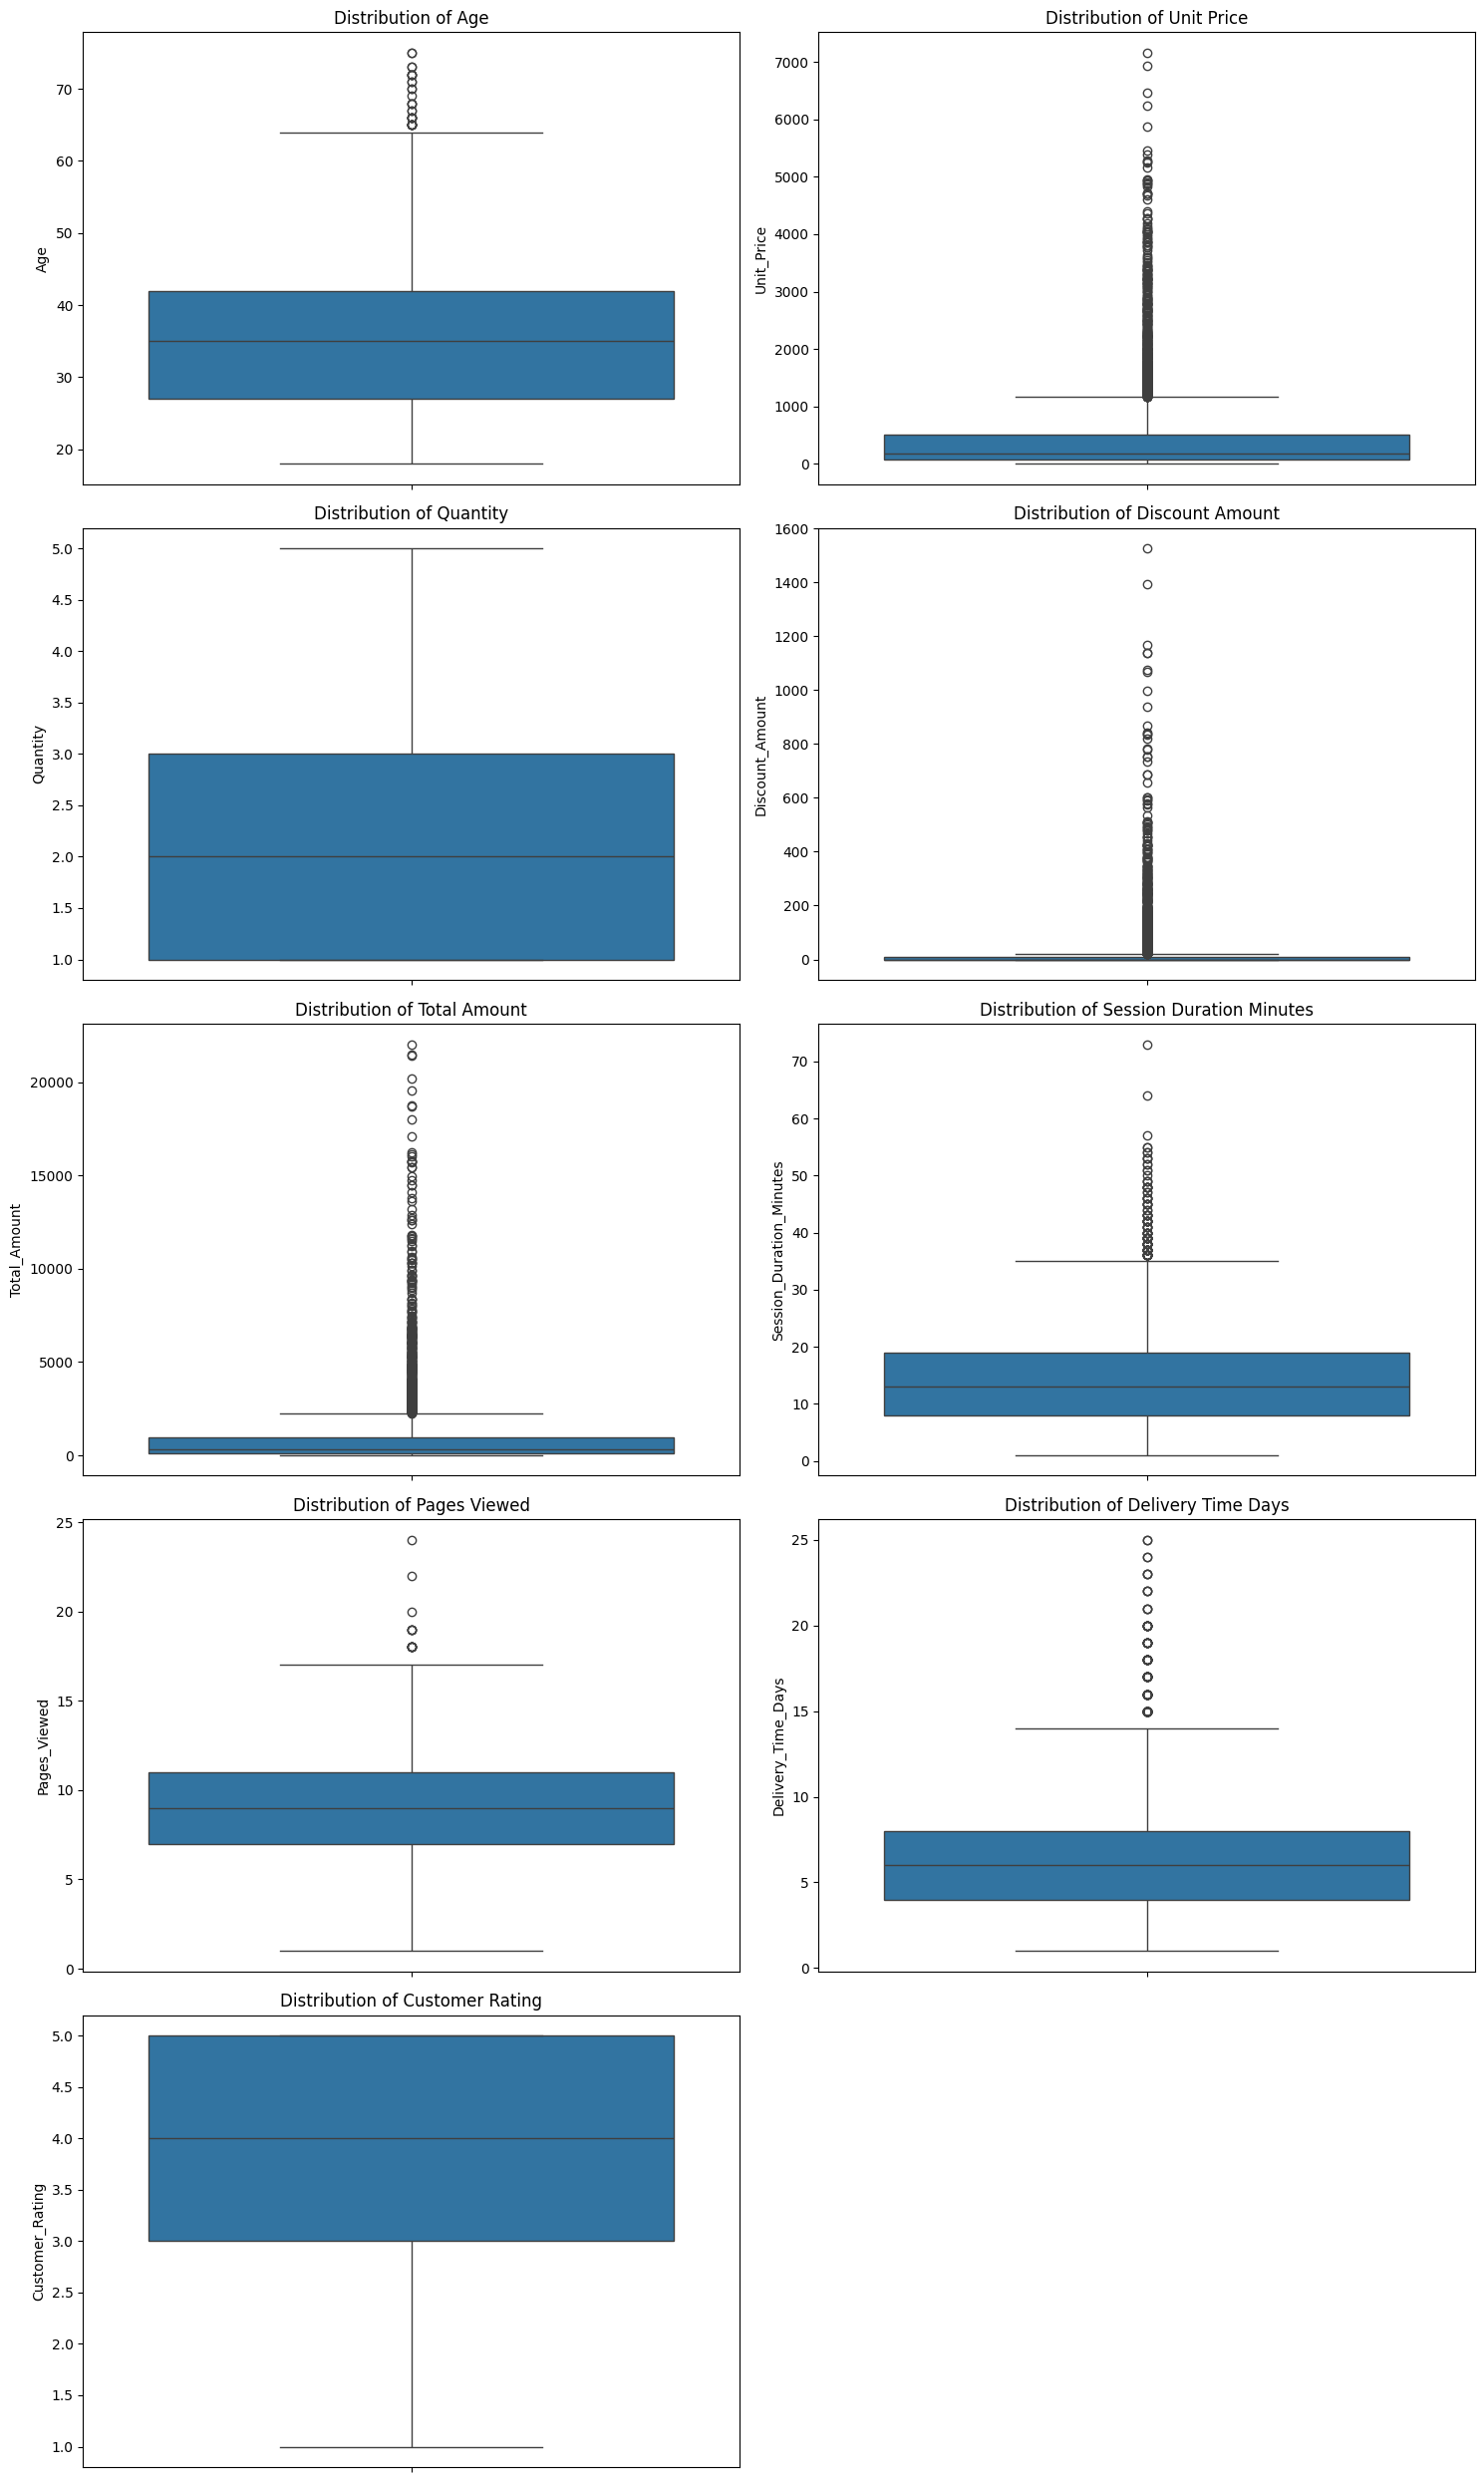

In [128]:
num_cols = df.select_dtypes(include=[np.number]).columns

n_cols =2 
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig,axes = plt.subplots(n_rows,n_cols, figsize=(15,5*n_rows))
axes = axes.flatten()

for i,col in enumerate(num_cols):
    sns.boxplot(df[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col.replace("_"," ").title()}')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### **Key Insights:**

- **Age**: Mostly concentrated between 25–45 years, with a few older customers appearing as mild outliers.

- **Unit Price** and **Total Amount** show several extreme values, indicating a few very high priced transactions that may be premium products.

- **Discount Amount** also contains noticeable outliers, likely corresponding to heavy promotional discounts.

- **Session Duration Minutes** and **Pages Viewed** include a few exceptionally high observations, possibly from highly engaged or indecisive customers.

- **Delivery Time Days** presents several outliers, suggesting occasional delayed deliveries beyond the normal range.

- **Customer Rating** is mostly consistent (centered around 4–5), showing very few outliers.

Overall, multiple features especially Unit Price, Total Amount, and Discount Amount contain significant outliers. These will be further investigated using the IQR method to determine whether they should be capped, transformed, or retained based on business relevance.

### **2.IQR**

In [129]:
# IQR method for outlier detection 

iqr_summary = []

for col in df.select_dtypes(include = [np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    percent_outliers = (outliers / df.shape[0]) * 100

    iqr_summary.append({'Columns':col,'Total Outliers':outliers, 
                        'Percent Outliers': f"{round(percent_outliers, 2)}%"})

iqr_summary_df = pd.DataFrame(iqr_summary)
print(iqr_summary_df)

                    Columns  Total Outliers Percent Outliers
0                       Age              30             0.6%
1                Unit_Price             513           10.26%
2                  Quantity               0             0.0%
3           Discount_Amount             879           17.58%
4              Total_Amount             546           10.92%
5  Session_Duration_Minutes             124            2.48%
6              Pages_Viewed              14            0.28%
7        Delivery_Time_Days             141            2.82%
8           Customer_Rating               0             0.0%


Outliers were detected using the IQR method. While some variables like Unit Price, Discount Amount, and Total Amount show substantial deviation, these outliers likely represent genuine customer or product variations rather than data errors. Therefore, they were retained for analysis

## **Overall customer demographics**

### **1 . Sales & Rating Performance by Gender**

In this section, we analyze customer purchasing behavior and satisfaction levels across different genders. The goal is to understand **which gender group contributes the most to overall revenue**, how **average spending per customer** varies, and whether there are **differences in customer satisfaction ratings**.

In [130]:
conn = sqlite3.connect("ecommerce_customer_behavior_dataset.db")
df.to_sql("ecommerce_data", conn, if_exists="replace", index=False)

5000

### **Total Sales and Average Sales by Gender**

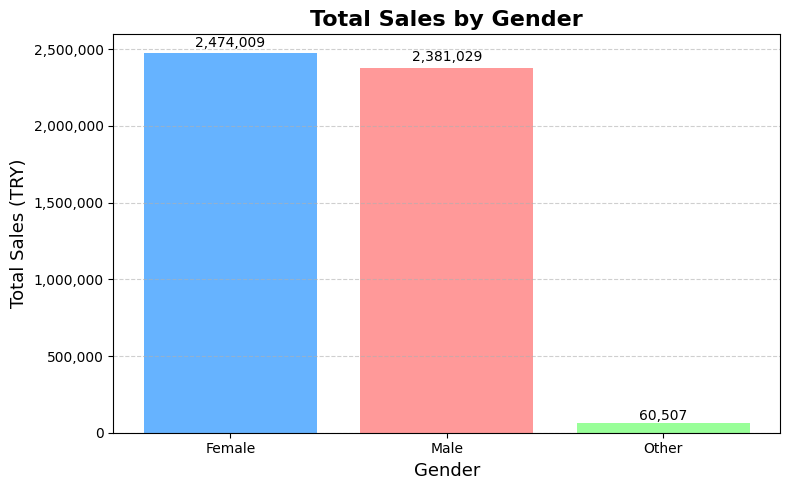

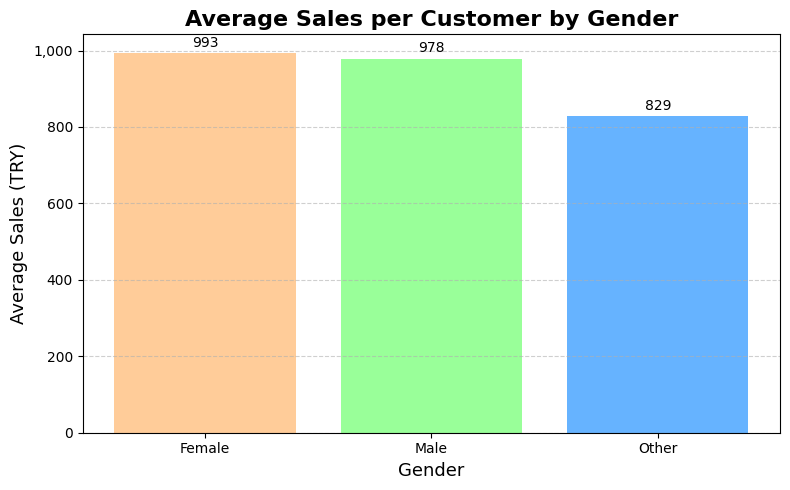

In [131]:
# sql query to get total and average sales
query = """
SELECT Gender, 
SUM(Total_Amount) as Total_Sales,
AVG(Total_Amount) as Avg_Sales_Per_Customer
FROM ecommerce_data
GROUP BY Gender
ORDER BY Total_Sales DESC;
"""

gender_sales = pd.read_sql_query(query, conn)

# Total Sales by Gender 
plt.figure(figsize=(8,5))
bars = plt.bar(
    gender_sales['Gender'],
    gender_sales['Total_Sales'],
    color=['#66b3ff', '#ff9999', '#99ff99']
)

plt.title('Total Sales by Gender', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=13)
plt.ylabel('Total Sales (TRY)', fontsize=13)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (yval * 0.01),
             f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Average Sales by Gender
plt.figure(figsize=(8,5))
bars = plt.bar(
    gender_sales['Gender'],
    gender_sales['Avg_Sales_Per_Customer'],
    color=['#ffcc99', '#99ff99', '#66b3ff']
)

plt.title('Average Sales per Customer by Gender', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=13)
plt.ylabel('Average Sales (TRY)', fontsize=13)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (yval * 0.01),
             f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### **Key Insights:**

The first chart **Total Sales by Gender** shows that both **female and male customers contribute nearly equal amounts of total revenue**, with females slightly ahead (≈ 2.47 million TRY vs 2.38 million TRY).  
The **"Other"** gender category contributes a much smaller share (≈ 60 k TRY).

In the second chart "**Average Sales per Customer by Gender**"  depicts that **female customers also lead slightly in average spending** (≈ 993 TRY per transaction), followed closely by males (≈ 978 TRY).  
Although the total contribution from “Other” customers is lower, their **average purchase value (≈ 829 TRY)** remains fairly close to the other groups.

Overall, these result indicate:

- **Revenue is balanced** between male and female buyers.
- **Female customers** display marginally higher individual spending and total contribution.  
- The **small “Other” segment** may represent an emerging demographic.

### Average Rating by Gender

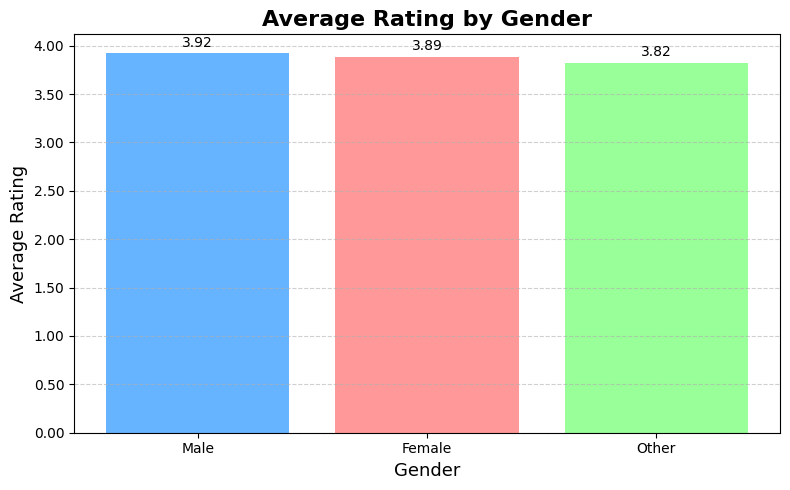

In [132]:
query = """
SELECT Gender,
AVG(Customer_Rating) as Avg_Rating
FROM ecommerce_data
GROUP BY Gender
ORDER BY Avg_Rating DESC;
"""

gender_avg_rating = pd.read_sql_query(query, conn)  

# Bar Plot
plt.figure(figsize=(8,5))
bar = plt.bar(gender_avg_rating['Gender'], 
        gender_avg_rating['Avg_Rating'], color=['#66b3ff', '#ff9999', '#99ff99'])
plt.title('Average Rating by Gender', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=13)
plt.ylabel('Average Rating', fontsize=13)   
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))    


for bar in bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (yval * 0.01),
             f'{yval:,.2f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### **Key Insights:**

- Male respondents gave the highest average rating (3.92), followed closely by Female (3.89) and Other (3.82).

- The differences among genders are very small, suggesting that gender does not strongly influence rating behavior in this dataset.

## **Product category performance**

This section evaluates how different product categories perform in terms of total sales, average sales per order, and average customer ratings. By comparing these metrics, we can identify the best-selling categories, understand customer preferences, and assess whether high sales align with higher satisfaction levels.

### **Total Sales and Average Sales by Categories**

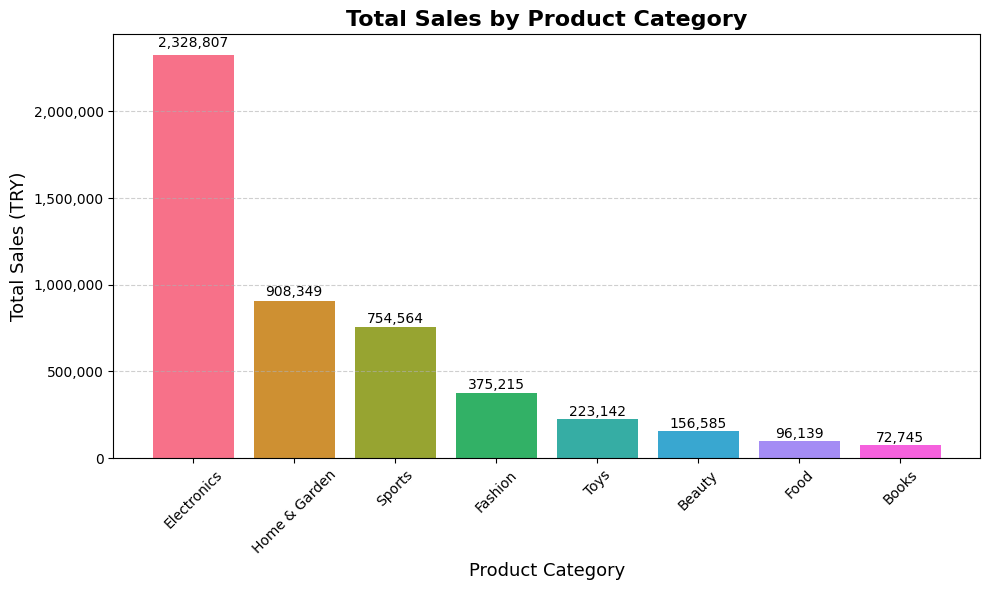

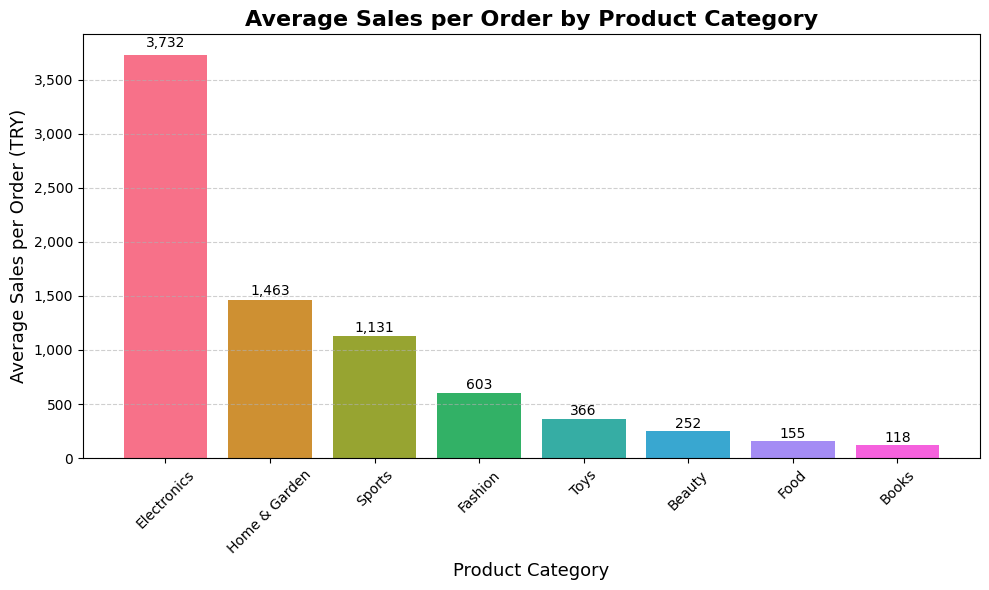

In [133]:
# sql query to get total and average sales by product category
query = """SELECT Product_Category, 
SUM(Total_Amount) as Total_Sales,
AVG(Total_Amount) as Avg_Sales_Per_Order
FROM ecommerce_data
GROUP BY Product_Category
ORDER BY Total_Sales DESC;
"""

# create data with sql query
cat_sales = pd.read_sql_query(query, conn)

# Plot Total Sales by Category
plt.figure(figsize=(10,6))
bars = plt.bar(
    cat_sales['Product_Category'],
    cat_sales['Total_Sales'],
    color=sns.color_palette("husl", len(cat_sales))
)
plt.title('Total Sales by Product Category', fontsize=16, fontweight='bold')
plt.xlabel('Product Category', fontsize=13)
plt.ylabel('Total Sales (TRY)', fontsize=13)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (yval * 0.01),
             f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)
    
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot Average Sales per Order by Category
plt.figure(figsize=(10,6))
bars = plt.bar(
    cat_sales['Product_Category'],
    cat_sales['Avg_Sales_Per_Order'],
    color=sns.color_palette("husl", len(cat_sales))
)
plt.title('Average Sales per Order by Product Category', fontsize=16, fontweight='bold')
plt.xlabel('Product Category', fontsize=13)
plt.ylabel('Average Sales per Order (TRY)', fontsize=13)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (yval * 0.01),
             f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)
    
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### **Key Insights:**

The first chart, **Total Sales by Product Category**, reveals that **Electronics** dominate total revenue, generating over **2.3 million TRY**, far ahead of all other categories. **Home & Garden (≈ 0.9M TRY)** and **Sports (≈ 0.75M TRY)** follow as mid-performing categories, while **Fashion, Toys, Beauty, Food, and Books** contribute smaller shares to overall sales.  

This suggests that high-value items like electronics and home products are the primary revenue drivers for the business.

In the second chart, **Average Sales per Order by Product Category**, a similar trend appears in terms of spending per transaction. **Electronics** again lead significantly, with an average order value of approximately **3,700 TRY**, indicating high-priced items and possibly fewer but larger transactions.  
**Home & Garden** and **Sports** categories also show relatively high average order values (≈ 1,400 TRY and 1,100 TRY, respectively).  

In contrast, **Books, Food, and Beauty** categories record much smaller average sales per order, reflecting low-cost, high-frequency purchases.


### **Overall Insights:**

- **Electronics** are the top-performing category both in total and average sales.

- **Home & Garden** and **Sports** present balanced opportunities for growth with strong spending potential.  

- **Lower-value categories** like Books and Food may rely on high transaction volume rather than per order value.  

---


## **Gender and Product Categories Performance**

This section examines how **sales performance and rating varies across different product categories and customer genders**.  By analyzing total spending patterns for each gender within each category, we can identify which products are most popular among specific demographic groups and where the company’s strongest revenue segments lie.

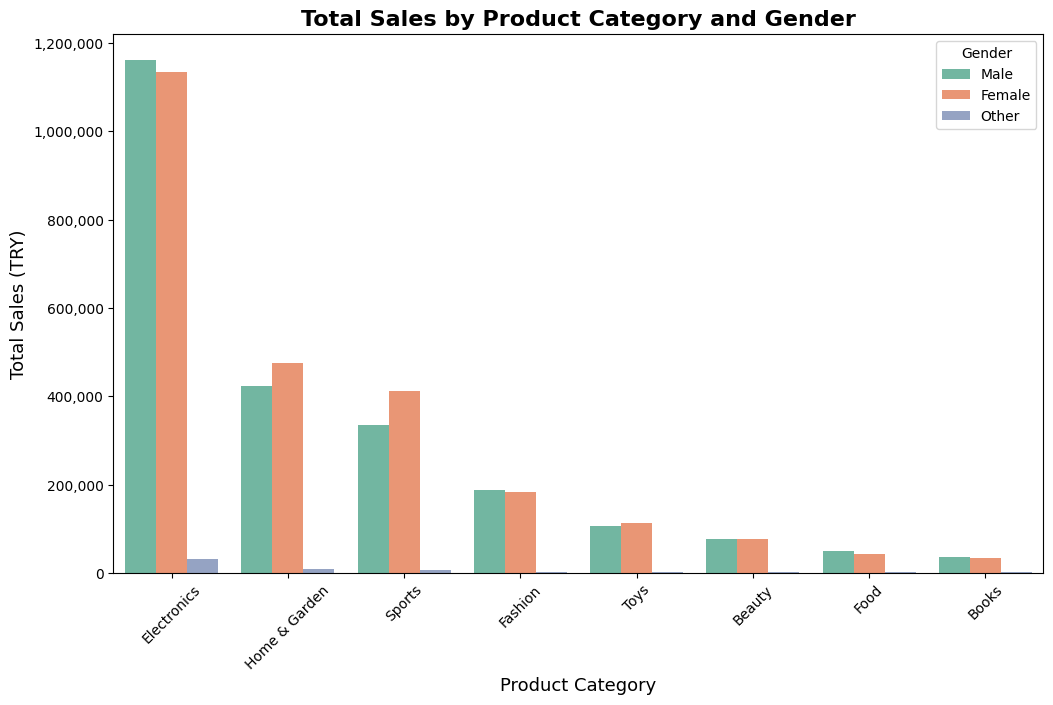

In [134]:
query = """
SELECT 
Product_Category, 
Gender,
SUM(Total_Amount) AS Total_Sales
FROM ecommerce_data
GROUP BY Product_Category, Gender
ORDER BY Product_Category DESC, Gender DESC
"""
cat_gender_sales = pd.read_sql_query(query, conn)
cat_gender_sales = cat_gender_sales.sort_values(by='Total_Sales', ascending= False)    

plt.figure(figsize=(12,7))
sns.barplot(
    data=cat_gender_sales,
    x='Product_Category',   
    y='Total_Sales',
    hue='Gender',
    palette='Set2'
)

plt.title('Total Sales by Product Category and Gender', fontsize=16, fontweight='bold')
plt.xlabel('Product Category', fontsize=13)
plt.ylabel('Total Sales (TRY)', fontsize=13)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

### **Interpretation - Total Sales by Product Category and Gender**

This plot compares total revenue generated by each product category across genders. 

Each product category contains three bars representing **male**, **female**, and **other** customers, allowing a direct comparison of spending patterns across demographic groups.

### **Key Insights:**

- **Electronics** dominate total revenue for all genders, with male and female customers contributing nearly equally.

- **Home & Garden** and **Sports** also generate substantial sales, again showing a relatively balanced gender distribution, though female customers slightly outspend males.  

- **Fashion**, **Toys**, and **Beauty** categories attract moderate sales volumes, with female customers showing marginally higher spending in most cases.  

- **Food** and **Books** contribute the least to overall sales across all genders, indicating smaller or more niche market segments.  

- The **"Other"** gender group shows significantly lower spending across all categories, likely due to a smaller representation in the dataset.

---


### **City-Level Sales Performance Analysis**

This section explores the performance of each city in terms of **total sales**, **average sales per order**, and **number of customers**.  

The objective is to identify which regions contribute most to overall revenue and understand differences in customer behavior across cities.


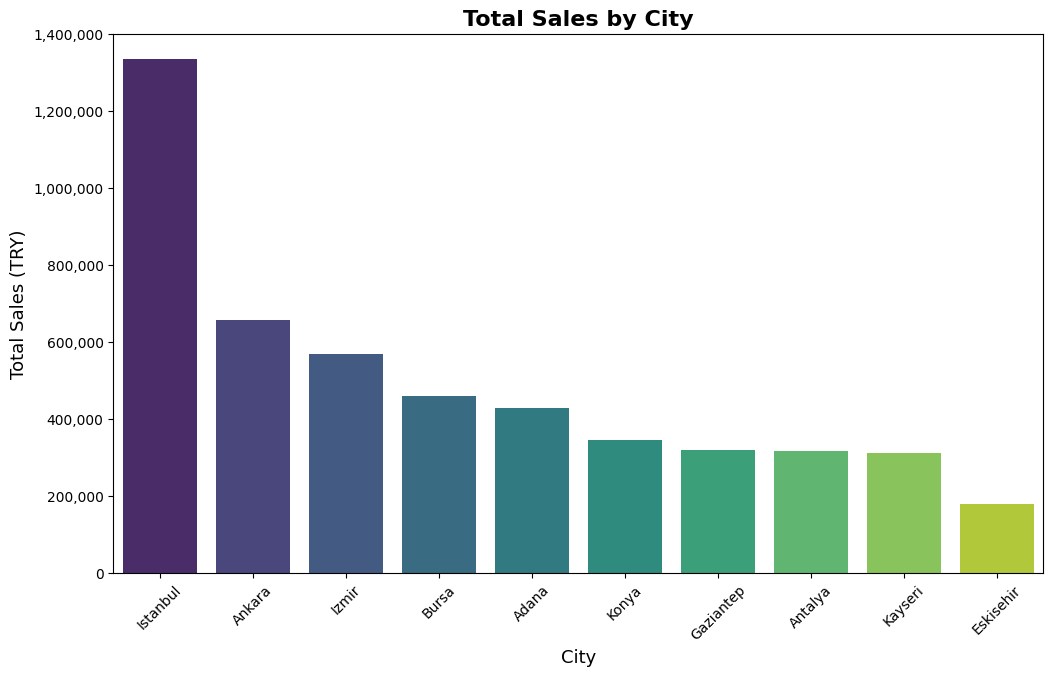

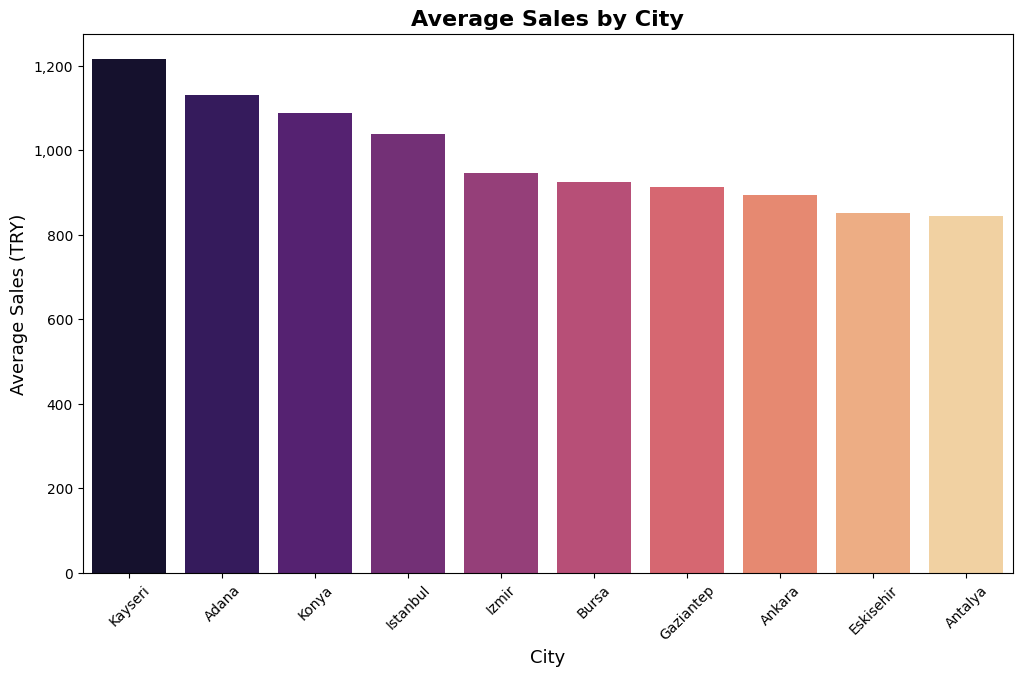

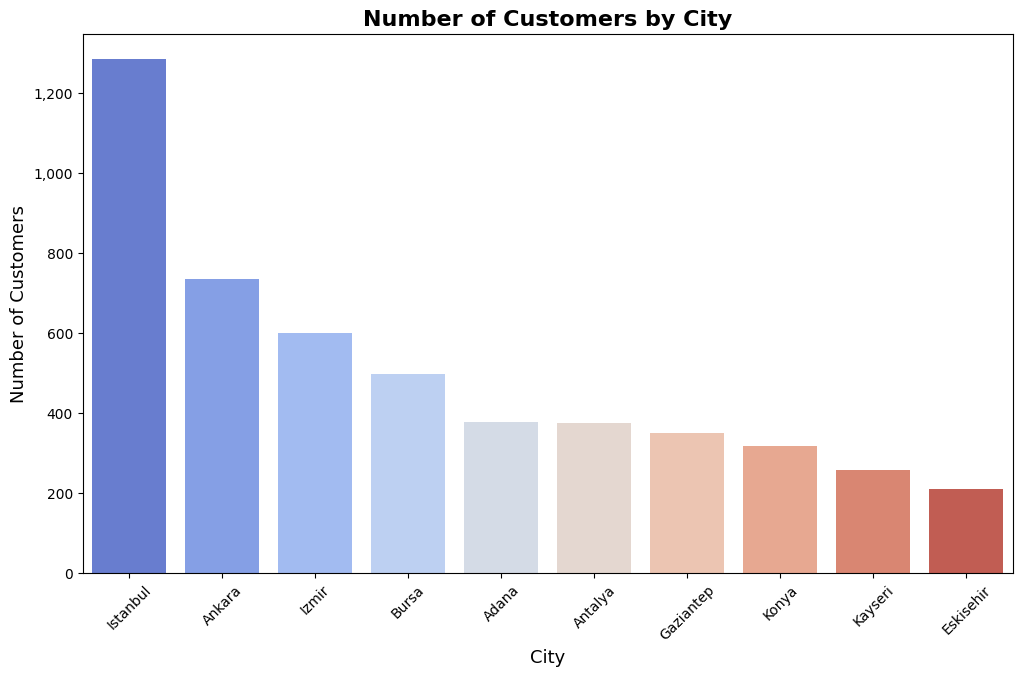

In [135]:
# sql query to get total and average sales by city
query = """
SELECT City, 
SUM(Total_Amount) AS Total_Sales,
AVG(total_Amount) AS Avg_Sales,
COUNT(DISTINCT Customer_ID) AS Num_Customers
FROM ecommerce_data
GROUP BY City
ORDER BY Total_Sales DESC
"""
city_sales = pd.read_sql_query(query, conn) 
city_sales = city_sales.sort_values(by='Total_Sales', ascending=False)

# Plot Total Sales by City
plt.figure(figsize=(12,7))
sns.barplot(
    data=city_sales,
    x='City',
    y='Total_Sales',
    palette='viridis'
)
plt.title('Total Sales by City', fontsize=16, fontweight='bold')
plt.xlabel('City', fontsize=13)
plt.ylabel('Total Sales (TRY)', fontsize=13)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=45)
plt.show()

# Plot Average Sales per Order by City
city_sales = city_sales.sort_values(by='Avg_Sales', ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(
    data=city_sales,
    x='City',
    y='Avg_Sales',
    palette='magma'
)
plt.title('Average Sales by City', fontsize=16, fontweight='bold')
plt.xlabel('City', fontsize=13)
plt.ylabel('Average Sales (TRY)', fontsize=13)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=45)
plt.show()

# Plot Number of Customers by City
city_sales = city_sales.sort_values(by='Num_Customers', ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(
    data=city_sales,
    x='City',
    y='Num_Customers',
    palette='coolwarm'
)
plt.title('Number of Customers by City', fontsize=16, fontweight='bold')
plt.xlabel('City', fontsize=13)
plt.ylabel('Number of Customers', fontsize=13)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=45)
plt.show()

#### **Total Sales by City**

- **Istanbul** clearly dominates with the highest total sales (~1.35 million TRY), more than double that of any other city.  

- **Ankara** and **Izmir** follow, indicating their importance as secondary revenue hubs.  

- Mid-sized cities such as **Bursa**, **Adana**, and **Konya** show moderate performance.  

- **Eskişehir** ranks the lowest in total sales, suggesting a smaller customer base or lower spending activity.

#### **Average Sales per Order by City**
- Interestingly, **Kayseri**, **Adana**, and **Konya** lead in *average sales per order*, exceeding even Istanbul, implying that while these cities have fewer customers, the **average transaction value** is relatively high.  

- **Istanbul** and **Izmir**, despite having strong overall sales, show moderate average order values 

- **Antalya** and **Eskişehir** have the lowest average sales per order, hinting at smaller basket sizes or more price-sensitive consumers.

#### **Number of Customers by City**

- **Istanbul** again ranks highest in total customer count, followed by **Ankara** and **Izmir**, aligning with their population and economic scale. 

- Cities like **Kayseri** and **Eskişehir** have significantly fewer customers, correlating with their lower total sales.  

- However, **Kayseri’s** high average order value suggests a smaller but more **valuable** customer segment.

---

### **Device usage and customer engagement.**

Understanding how customers interact with different devices provides valuable insight into their engagement behavior and purchasing patterns.

In [136]:
# sql query to get sales by device type
query = """
SELECT
Device_Type,
COUNT(Customer_ID) AS customer_count,
SUM(Total_Amount) AS total_sales,
AVG(Total_Amount) AS avg_sales_per_customer
FROM ecommerce_data
GROUP BY Device_Type
"""
device_sales = pd.read_sql_query(query, conn)

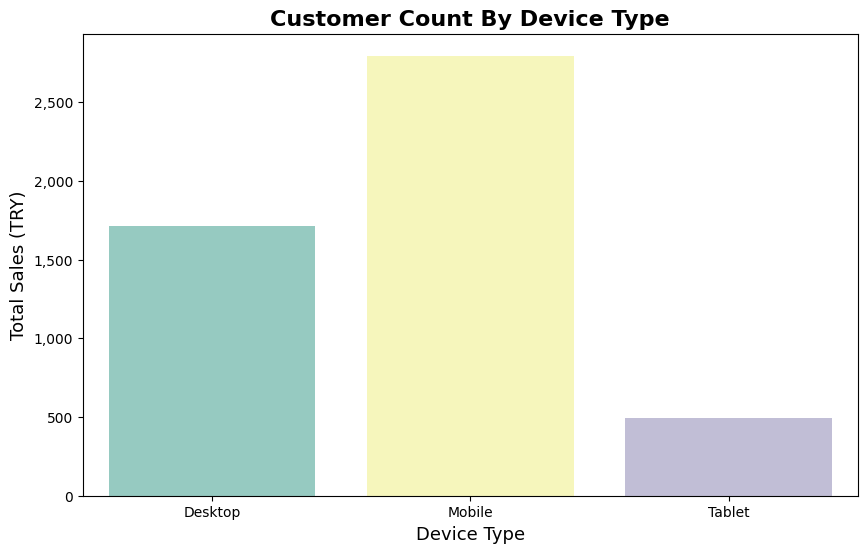

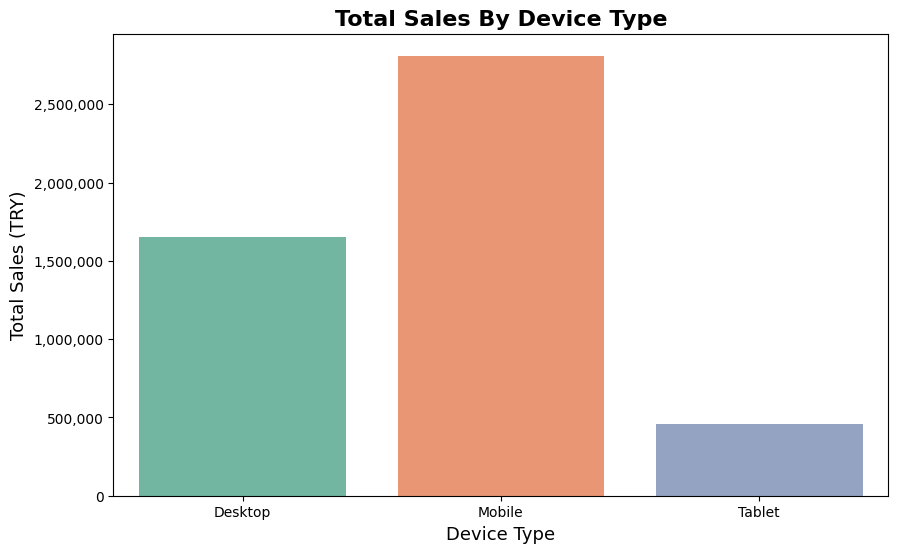

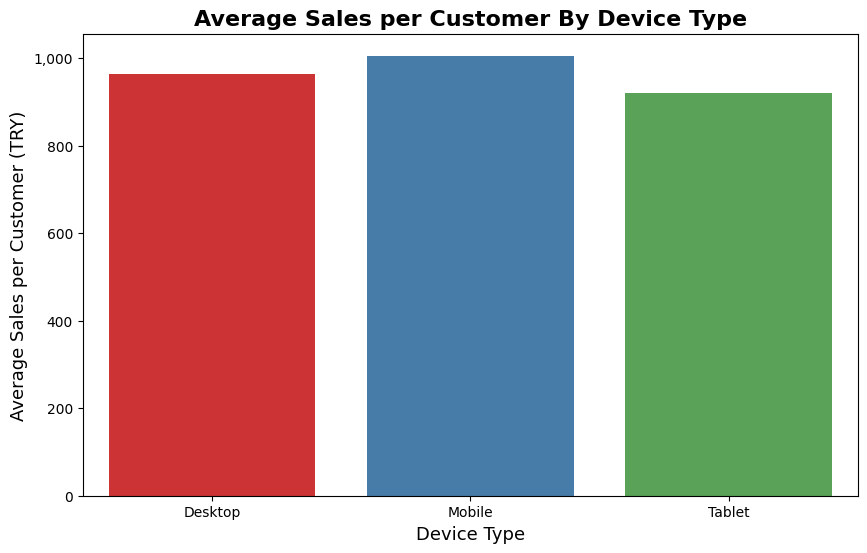

In [137]:
# Plot Customer Count by Device Type
plt.figure(figsize=(10,6))
sns.barplot(data = device_sales,
            x = 'Device_Type',
        y = 'customer_count',
        palette = 'Set3')
plt.title('Customer Count By Device Type', fontsize=16, fontweight='bold')
plt.xlabel('Device Type', fontsize=13)
plt.ylabel('Total Sales (TRY)', fontsize=13)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

# Plot Total Sales by Device Type
plt.figure(figsize=(10,6))
sns.barplot(data = device_sales,
            x = 'Device_Type',
        y = 'total_sales',
        palette = 'Set2')
plt.title('Total Sales By Device Type', fontsize=16, fontweight='bold')
plt.xlabel('Device Type', fontsize=13)
plt.ylabel('Total Sales (TRY)', fontsize=13)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

# Plot Average Sales per Customer by Device Type
plt.figure(figsize=(10,6))
sns.barplot(data = device_sales,
            x = 'Device_Type',
        y = 'avg_sales_per_customer',
        palette = 'Set1')
plt.title('Average Sales per Customer By Device Type', fontsize=16, fontweight='bold')
plt.xlabel('Device Type', fontsize=13)
plt.ylabel('Average Sales per Customer (TRY)', fontsize=13) 
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


### **Costomer Count by Device Type.**

- **Mobile devices** record the highest number of customers, depicting that most users prefer browsing through their smartphones.

- **Desktop** follows as the second most used device.

- **Tablet usage** is minimal, indicating it is the least common medium for customer interaction.

### **Total Sales by Device Type.**

- **Mobile devices** again dominate with the highest total sales volume.

- **Desktop** contributes significantly but remains below mobile sales.

- **Tablet** shows the lowest total sales.

### **Average Sales per Customer by Device type.**

- Mobile users spend, on average, slightly higher than other type of device.

Overall, the results highlights the dominant influence of mobile device, making it a primary chanel for engagement and revenue generation.

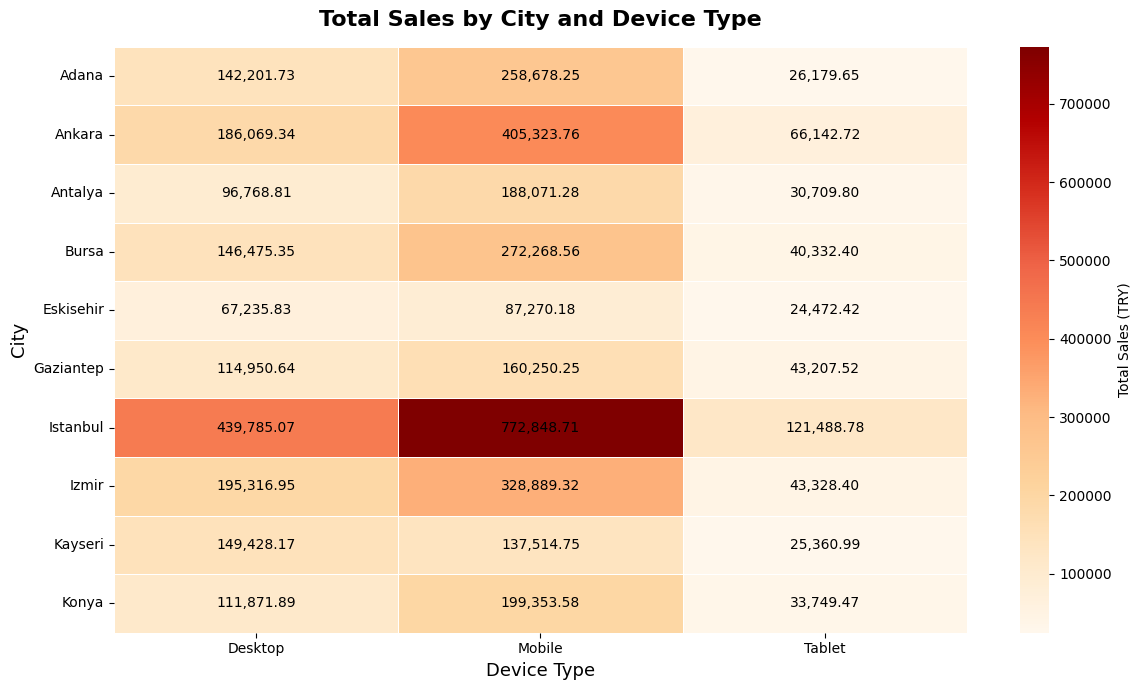

In [138]:
# plot pivot table as heatmap
pivot_table = df.pivot_table(index='Device_Type', columns='City', values='Total_Amount', aggfunc='sum').T
# --- Plot better heatmap ---
plt.figure(figsize=(12,7))
sns.heatmap(
    pivot_table,
    annot=True,                
    fmt=",.2f",                   
    cmap='OrRd',             
    linewidths=0.5,            
    linecolor='white',
    cbar_kws={'label': 'Total Sales (TRY)'},  
    annot_kws={'size': 10, 'color': 'black'}  
)

# --- Titles and labels ---
plt.title('Total Sales by City and Device Type', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Device Type', fontsize=13)
plt.ylabel('City', fontsize=13)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **Key Insights:**

- **Mobile devices** consistently generate the highest revenue across nearly all cities

- **Desktop sales** remain relevant in major cities (especially Istanbul and Ankara) but trail behind mobile totals.

- **Tablet sales** are the weakest across all regions, suggesting limited consumer preference for this platform.

### **Device Type By Gender**

Text(120.72222222222221, 0.5, 'Device Type')

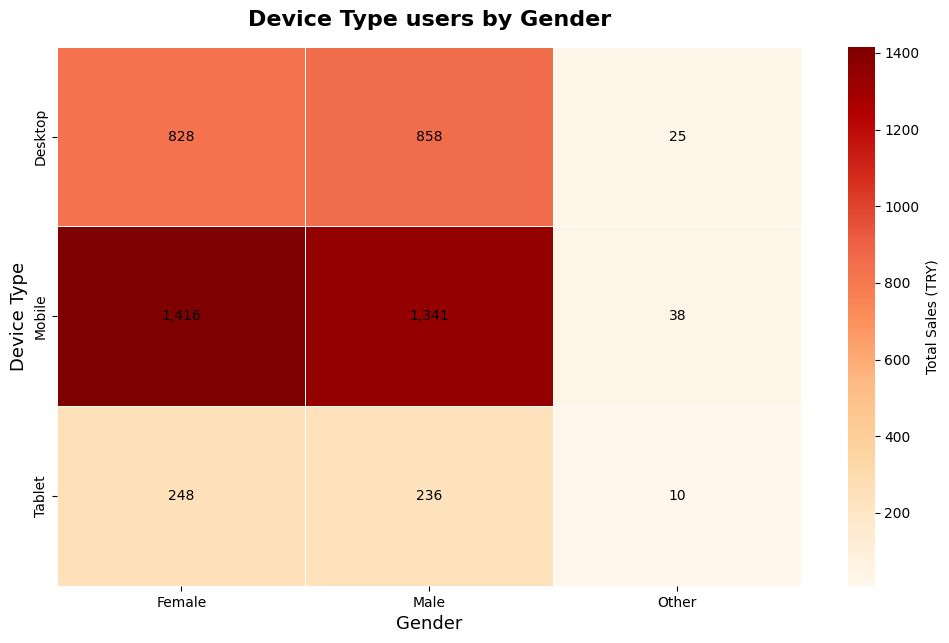

In [139]:
pivot_table = df.pivot_table(index='Device_Type', columns='Gender', values='Customer_ID', aggfunc='count')
# --- Plot better heatmap ---   
plt.figure(figsize=(12,7))
sns.heatmap(
    pivot_table,
    annot=True,                
    fmt=",.0f",                   
    cmap='OrRd',             
    linewidths=0.5,            
    linecolor='white',
    cbar_kws={'label': 'Total Sales (TRY)'},  
    annot_kws={'size': 10, 'color': 'black'}  
)   

plt.title('Device Type users by Gender', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Gender', fontsize=13)
plt.ylabel('Device Type', fontsize=13)

### **Key Insights:**

- Mobile device dominates in both male and female customer, followed by the desktop.

- Tablet is the least popular platform usaged among all type of genders, indicating limited access of the device.

## **Correlations Heatmap of all Features**

In [140]:
# Transform boolean to integer
df['Is_Returning_Customer'] = np.where(df['Is_Returning_Customer'] == True, 1, 0)

<Axes: >

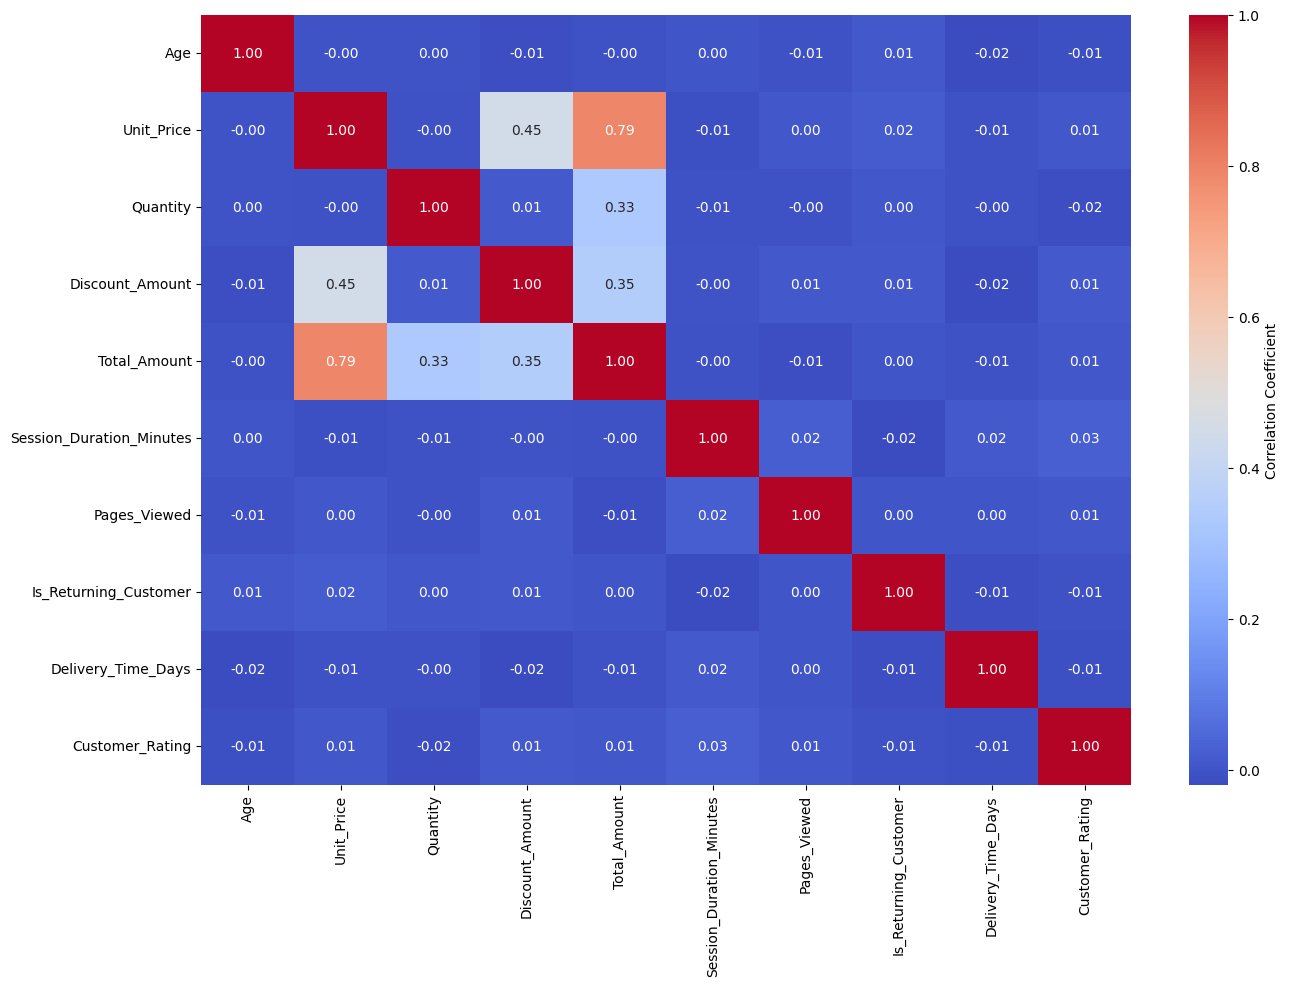

In [141]:
plt.figure(figsize=(15,10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})

In [142]:
df.columns

Index(['Order_ID', 'Customer_ID', 'Date', 'Age', 'Gender', 'City',
       'Product_Category', 'Unit_Price', 'Quantity', 'Discount_Amount',
       'Total_Amount', 'Payment_Method', 'Device_Type',
       'Session_Duration_Minutes', 'Pages_Viewed', 'Is_Returning_Customer',
       'Delivery_Time_Days', 'Customer_Rating'],
      dtype='object')

### **Key Insights:**

- All price-related features exhibit moderate correlations, which is expected given that they are derived from similar transactional components.

- Other variables show little to no correlation, indicating that they are largely independent of one another.

## **4. Modelling**

In this section, various clustering algorithms are applied to identify distinct customer segments based on their purchasing behavior and engagement patterns. The objective is to group customers with similar characteristics to help businesses tailor their marketing strategies.

The following clustering methods are explored:

- K- Means Clustering 
- K-Prototypes Clusering 
- Hierarchical clustering
- DBSCAN
- GMM

In [185]:
# Drop non-numeric or identifier columns
df = df.drop(columns = ['Customer_ID','Order_ID','Date'],axis = 1)

In [186]:
df.columns

Index(['Age', 'Gender', 'City', 'Product_Category', 'Unit_Price', 'Quantity',
       'Discount_Amount', 'Total_Amount', 'Payment_Method', 'Device_Type',
       'Session_Duration_Minutes', 'Pages_Viewed', 'Is_Returning_Customer',
       'Delivery_Time_Days', 'Customer_Rating'],
      dtype='object')

### **4.1 K-Means Clustering**

The K-Means algorithm was applied as the baseline clustering method to segment customers based on their purchasing and engagement behaviors. This technique partitions the dataset into `k` clusters by minimizing the distance between data points and their respective cluster centroids. 

Before fitting the model, all numerical features were standardized to ensure equal contribution to the clustering process. 

The optimal number of clusters was determined using the Elbow Method and Silhouette Score, followed by PCA visualization to examine the separation and structure of the resulting customer groups.

In [187]:
# Identify numeric and categorical features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features =df.drop(columns=numeric_features).columns.tolist()
# Create transformers for numeric and categorical features
numeric_transformer = StandardScaler()
categorical_transform = OneHotEncoder(drop='first',handle_unknown='ignore')

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transform, categorical_features)
    ])

# Define the KMeans clustering model
kmeans = KMeans(n_clusters=5, random_state=42)

# Create the pipeline
pipeline = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('clustering', kmeans)
])

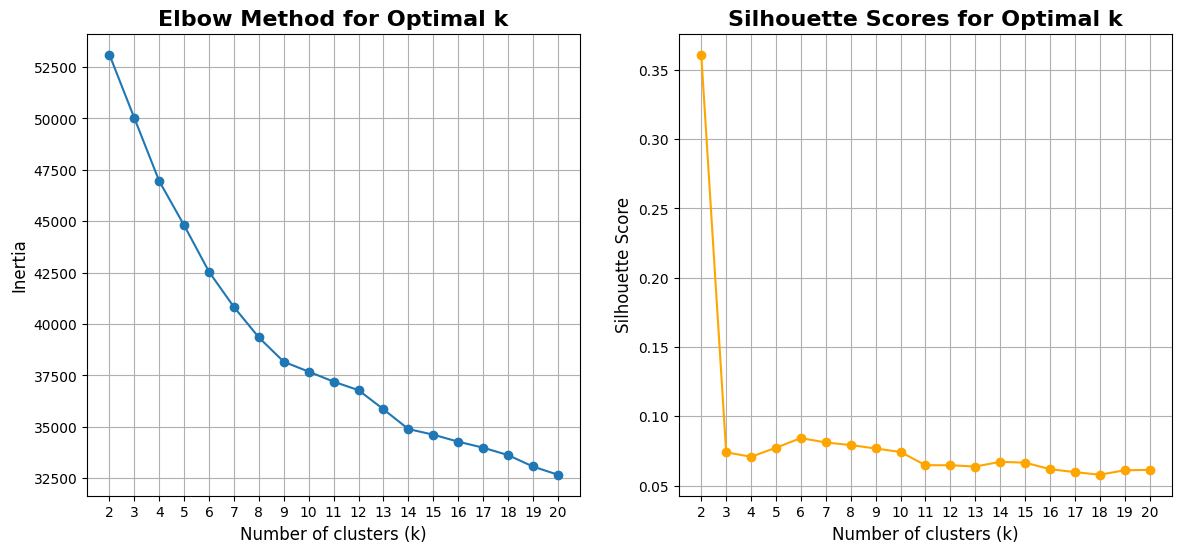

In [188]:
# Fit the pipeline to the data
preprocessed_data = pipeline.named_steps['preprocessor'].fit_transform(df)

inertia = []
silhouette_scores = []

# Evaluate KMeans for k values from 2 to 20
for k in range(2,21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(preprocessed_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(preprocessed_data, kmeans.labels_))


# Plot Inertia and Silhouette Scores

# Inertia
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(range(2,21), inertia, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=16, fontweight='bold')
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(range(2,21))
plt.grid(True)

# Silhouette Scores
plt.subplot(1,2,2)
plt.plot(range(2,21), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Optimal k', fontsize=16, fontweight='bold')
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(range(2,21))
plt.grid(True)
plt.show()

### **Key Insights:**

- **The Elbow Method** shows a sharp decrease at k =2, then the curve steadily hover at the same level.

- **The Silhouette Score** reaches its `maximum at k = 2` and decreases sharply afterward. This suggests that while two clusters provide the clearest separation, additional clusters begin to overlap and reduce distinctness between groups.

- The combination of both metrics implies that the dataset does not exhibit very strong natural partitions.


### **PCA Visualization of Clusters (k = 2)**

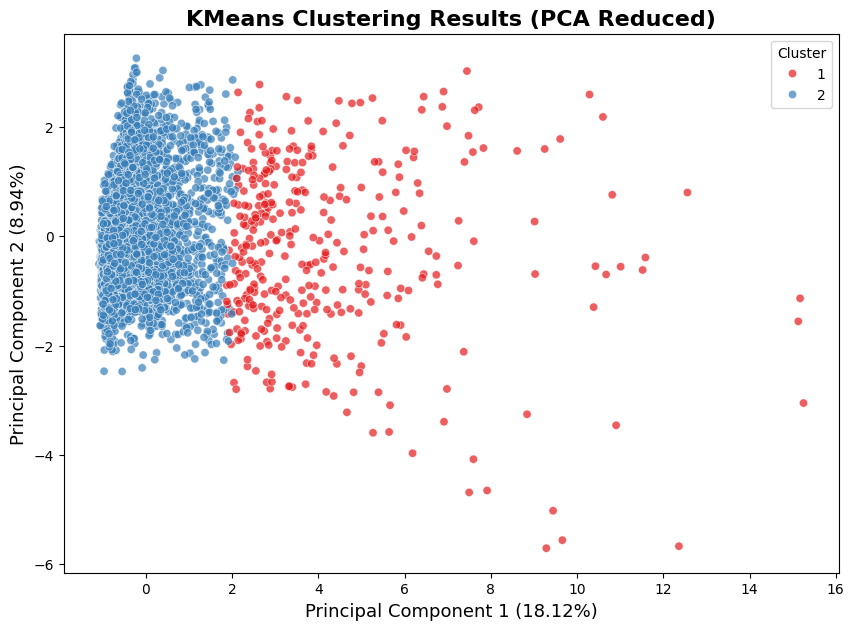

In [193]:
kmeans_df = df.copy()

kmeans_final = KMeans(n_clusters=2, random_state=42)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', kmeans_final)
])

final_pipeline.fit(kmeans_df)
kmeans_df['Cluster_kmeans'] = final_pipeline.named_steps['kmeans'].labels_+1

preprocessed_data = final_pipeline.named_steps['preprocessor'].transform(kmeans_df)

# PCA plot
pca = PCA(n_components=2,random_state=42)
pca_result = pca.fit_transform(preprocessed_data)
pca_kmeans_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_kmeans_df['Cluster_kmeans'] = kmeans_df['Cluster_kmeans']

var1_kmeans = pca.explained_variance_ratio_[0] * 100
var2_kmeans = pca.explained_variance_ratio_[1] * 100


plt.figure(figsize=(10,7))
sns.scatterplot(
    data=pca_kmeans_df, x='PC1', y='PC2',
    hue='Cluster_kmeans', palette='Set1',
    alpha=0.7
)
plt.title('KMeans Clustering Results (PCA Reduced)', fontsize=16, fontweight='bold')
plt.xlabel(f'Principal Component 1 ({var1_kmeans:.2f}%)', fontsize=13)
plt.ylabel(f'Principal Component 2 ({var2_kmeans:.2f}%)', fontsize=13)
plt.legend(title='Cluster')
plt.show()


### **Key Insights:**

- Cluster 1 is much more dispersed across the PCA plane. This suggests Cluster 1 is composed of customers with more diverse spending patterns.

- Cluster 2 forms a dense, well-grouped block on the left side of the PCA space. This suggests Cluster 2 represents a large group of customers sharing similar behavioral and demographic patterns.

In [194]:
kmeans_final = KMeans(n_clusters=2, random_state=42)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', kmeans_final)
])

final_pipeline.fit(df)
kmean_df = df.copy()
kmean_df['Cluster'] = final_pipeline.named_steps['kmeans'].labels_ + 1  # Start cluster labels from 1

cluster_summary = kmean_df.groupby('Cluster')[numeric_features].mean().round(2)
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
           Age  Unit_Price  Quantity  Discount_Amount  Total_Amount  \
Cluster                                                               
1        34.30     2420.30      2.75           179.27       5924.08   
2        35.09      302.96      2.18            12.84        598.61   

         Session_Duration_Minutes  Pages_Viewed  Delivery_Time_Days  \
Cluster                                                               
1                           14.48          8.93                6.46   
2                           14.58          8.99                6.50   

         Customer_Rating  
Cluster                   
1                   3.94  
2                   3.90  


### **Cluster Interpretation (K-Means, K = 2)**
The K-Means model grouped customers into two distinct segments based primarily on their spending behavior and purchase value.

### **Key Insights:**

**Cluster1 - High Spending Customers**
- Demographics: Average age $\approx 34$ years
- Spending Behavior:
    - Very high unit price ($\approx 2,420$) and total spending ($\approx 5,924$)
    - Revieve larger discounts ($\approx 179$)
    - Purchase slightly more items per order ($\approx 2.8$)
- Engagement:
    - Average session durations $\approx 14.5$ minutes and 9 pages viewd
    - Slightly higer share of returning custommers

These are high-value buyers who tend to purchase more expensive items, often benefiting from discounts or promotions.They represent the most profitable segment, suitable for loyalty programs and premium deals

**Cluster2 - Budget-Oriented Customers**

- Demographics: Average age $\approx 35$ years
- Spending Behavior:
    - Low unit price ($\approx 303$) and total spending ($\approx 5,99$)
    - Revieve smaller discounts ($\approx 13$)
    - Buy slightly less items per order ($\approx 2.2$)
- Engagement:
    - Average session durations $\approx 14.6$ minutes and 9 pages viewd
    - Returning rate ($\approx 60%$) similar to Cluster1

This segment includes budget-conscious customers who prefer low-cost items and make smaller purchases.
They are steady shoppers, but could be encouraged to spend more through bundle offers, loyalty rewards, or discount campaigns.

### **t-SNE Visualization of K-Means Clusters**

The plot above shows the two clusters discovered by the K-Means algorithm, projected into two dimensions using t-SNE.

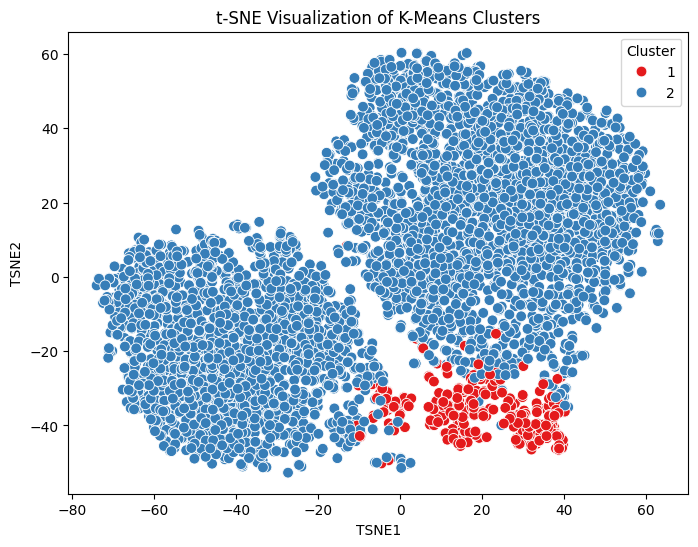

In [148]:
# Transform data using the preprocessor
X_transformed = final_pipeline.named_steps['preprocessor'].transform(df)

# Run t-SNE 
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(X_transformed)

# Create a DataFrame for plotting 
tsne_kmeans_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_kmeans_df['Cluster'] = kmean_df['Cluster']
# Plot the clusters 
plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_kmeans_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set1', s=60)
plt.title('t-SNE Visualization of K-Means Clusters')
plt.legend(title='Cluster')
plt.show()

### **Key Insights:**

- Cluster 1 (red) forms a smaller, compact region near the lower-center area, suggesting that this group is more homogeneous and shares similar purchase behaviors.

- Cluster 2 (blue) occupies a much larger portion of the plot, with several dense regions and a wider spread, indicating greater variation within this customer group.

- The clear color separation shows that the clusters are reasonably well defined, though some overlap still occurs.

--- 

### **4.2 K-Prototypes Clustering**

The K-Prototypes algorithm was applied as an extension to K-Means to effectively handle both numerical and categorical features within the dataset. 

Unlike K-Means, which relies solely on Euclidean distance, K-Prototypes combines `K-Means` (for numeric attributes) and `K-Modes` (for categorical attributes) to compute a mixed dissimilarity measure. 

This approach allows for more accurate segmentation in datasets that include variables such as gender, city, payment method, and device type. The model aims to uncover deeper customer patterns that reflect both behavioral and demographic similarities.

In [149]:
# Drop cluster column for K-Prototypes
df_kproto = df.copy()

# Identify categorical feature
cat_cols = df_kproto.select_dtypes(include=['object','category']).columns.tolist()

# Convert categorical columns to string type
for col in cat_cols:
    df_kproto[col] = df_kproto[col].astype('str')


# Scale numeric values
df_encoded = pd.get_dummies(df_kproto, drop_first=True)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)


# Apply K-Prototypes
results = []

for k in range(2,11):
    print(f"Running K-Prototypes for k={k}")
    try:
        kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
        clusters = kproto.fit_predict(
            df_kproto,
            categorical=[df_kproto.columns.get_loc(col) for col in cat_cols]
        )

        sil = silhouette_score(scaled_data, clusters)
        calinski = calinski_harabasz_score(scaled_data, clusters)
        davies = davies_bouldin_score(scaled_data, clusters)
        cost = kproto.cost_

        results.append({
            'K': k,
            'Cost': round(cost, 2),
            'Silhouette': round(sil, 4),
            'Calinski-Harabasz': round(calinski, 4),
            'Davies-Bouldin': round(davies, 4)
        })
    except Exception as e:
        print(f"Skipped k={k} due to error: {e}")
        continue

results_df = pd.DataFrame(results)
print(results_df)

Running K-Prototypes for k=2
Running K-Prototypes for k=3
Running K-Prototypes for k=4
Running K-Prototypes for k=5
Running K-Prototypes for k=6
Running K-Prototypes for k=7
Running K-Prototypes for k=8
Running K-Prototypes for k=9
Skipped k=9 due to error: Clustering algorithm could not initialize. Consider assigning the initial clusters manually.
Running K-Prototypes for k=10
Skipped k=10 due to error: Clustering algorithm could not initialize. Consider assigning the initial clusters manually.
   K          Cost  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  2  8.162818e+09      0.1988           223.8211          2.1801
1  3  4.189458e+09      0.0987           156.0668          2.9725
2  4  2.770210e+09      0.0514           122.1371          4.0651
3  5  2.106089e+09      0.0293            99.7190          4.9785
4  6  1.635281e+09      0.0228            82.2867          5.4031
5  7  1.378556e+09      0.0230            74.5762          5.2652
6  8  1.166111e+09      0.0155       

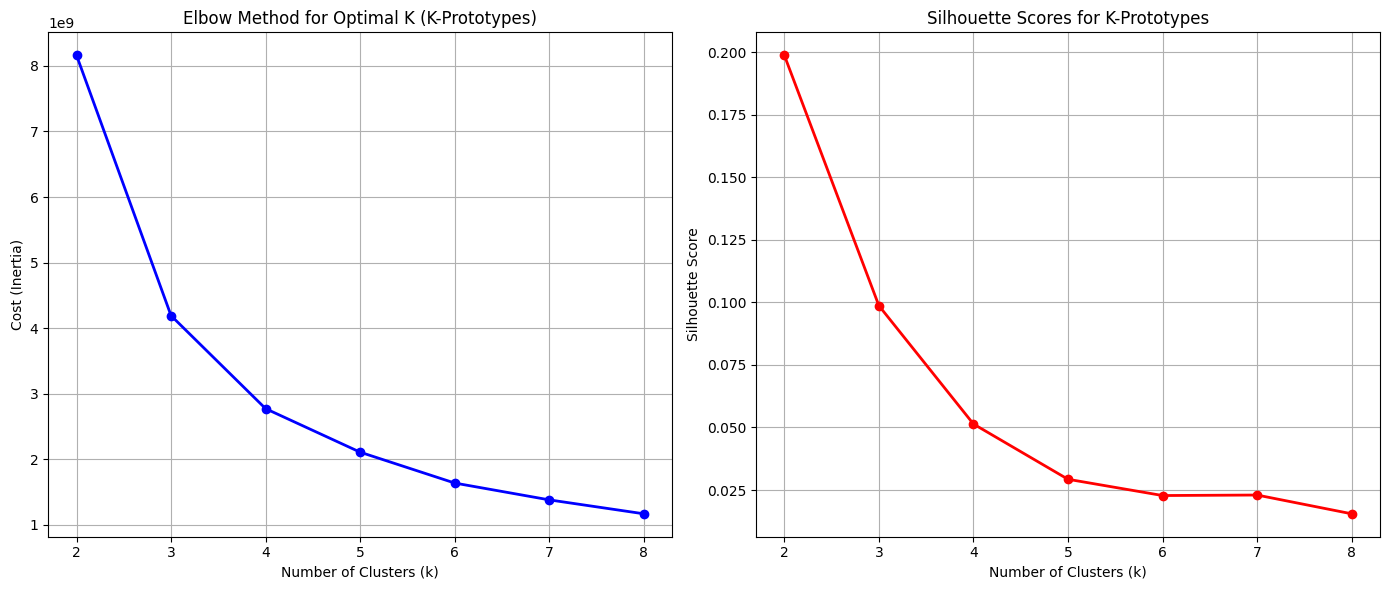

In [ ]:
# plot results
plt.figure(figsize=(14,6))

# --- Elbow Plot (Cost) ---
plt.subplot(1, 2, 1)
plt.plot(results_df['K'], results_df['Cost'], 'bo-', linewidth=2)
plt.title('Elbow Method for Optimal K (K-Prototypes)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (Inertia)')
plt.grid(True)

# --- Silhouette Plot ---
plt.subplot(1, 2, 2)
plt.plot(results_df['K'], results_df['Silhouette'], 'ro-', linewidth=2)
plt.title('Silhouette Scores for K-Prototypes')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

### **Key Insights:**

- **The Elbow plot** shows a steep decline in cost from k =2 to around k =5. After that it begins to flatten. This suggests diminishing improvement in model fit as more clusters are added.

- **The Silhouette Score** reaches its maximum at k=2 and drops sharply afterward, indicating two clusters provide the clearest separation.

- Therefore, 2-4 clusters solution may provice the most meaningful segmentation.

In [ ]:
final_kproto = KPrototypes(n_clusters=2, init='Cao', verbose=0, random_state=42)
final_clusters = final_kproto.fit_predict(
    df_kproto,
    categorical=[df_kproto.columns.get_loc(col) for col in cat_cols]
)
df_kproto['Cluster'] = final_clusters + 1  # Start cluster labels from 1

numeric_col = df_kproto.select_dtypes(include=[np.number]).columns.tolist()
cluster_summary_kproto = df_kproto.groupby('Cluster')[numeric_col].mean().round(2)
print("K-Prototypes Cluster Summary:")
print(cluster_summary_kproto)

K-Prototypes Cluster Summary:
           Age  Unit_Price  Quantity  Discount_Amount  Total_Amount  \
Cluster                                                               
1        35.08      341.08      2.15            18.88        624.14   
2        34.18     2466.22      3.42           129.43       7271.66   

         Session_Duration_Minutes  Pages_Viewed  Is_Returning_Customer  \
Cluster                                                                  
1                           14.61          8.99                   0.60   
2                           13.89          8.95                   0.59   

         Delivery_Time_Days  Customer_Rating  Cluster  
Cluster                                                
1                      6.50             3.90      1.0  
2                      6.47             3.94      2.0  


In [152]:
for col in cat_cols:
    print(df_kproto.groupby('Cluster')[col].agg(lambda x: x.value_counts().index[0]))

Cluster
1      Male
2    Female
Name: Gender, dtype: object
Cluster
1    Istanbul
2    Istanbul
Name: City, dtype: object
Cluster
1    Electronics
2         Sports
Name: Product_Category, dtype: object
Cluster
1    Credit Card
2    Credit Card
Name: Payment_Method, dtype: object
Cluster
1    Mobile
2    Mobile
Name: Device_Type, dtype: object


### **Cluster Interpretation - K-Prototyped Clustering**

The K-Prototypes model identified two main customer clusters, representing distinct purchasing and behavioral patterns.

Both clusters share some similarities, but differ notably in price sensitivity and product preferences.

### **Key Insights:**

**Cluster1 - High value and Electronic focused customer**
- **Demographic**: Average age $\approx 34$ years, predominantly Male.
- **Purchasing Behavior**:
    - Highest unit price ($\approx 2466$) and total amount ($\approx 7272$)
    - Purchase larger quantities per order (around 3.42 units)
    - Recieve higher discount on average
- **Product Category**: Electornics
- **Chanel** : Mobile Phone
- **Payment**: Credit Card
- **Engagement**: Slightly shorter session duration ($\approx 13.9$) and similar pages views
- **Rating**: Slightly higher in rating  ($\approx 3.94$)

These are high spending buyers who prefer electronics and shop through mobile devices, making larger purchases per order.

**Cluster2 - Budget Conscious and Sports oriented customers**
- Demographic: Average age $\approx 35$ years, predominantly Female.
- Purchasing Behavior:
    - Lowerr unit price ($\approx 341$) and total amount ($\approx 624$)
    - Purchase lower quantities per order (around 2.15 units)
    - Minimal discount usage ($\approx 19$)
- Chanel : Mobile Phone
- Product Category: Sport 
- Payment: Credit Card
- Engagement: Slightly longer session duration ($\approx 14.6$) and similar pages views
- Rating: Slightly lower in rating  ($\approx 3.9$)

This group includes budget-conscious shoppers who usually make smaller, lower-priced purchases in categories like sports items. They tend to browse longer before buying, showing a more cautious or price-aware shopping style.


### **PCA Visualization of K-Prototypes**

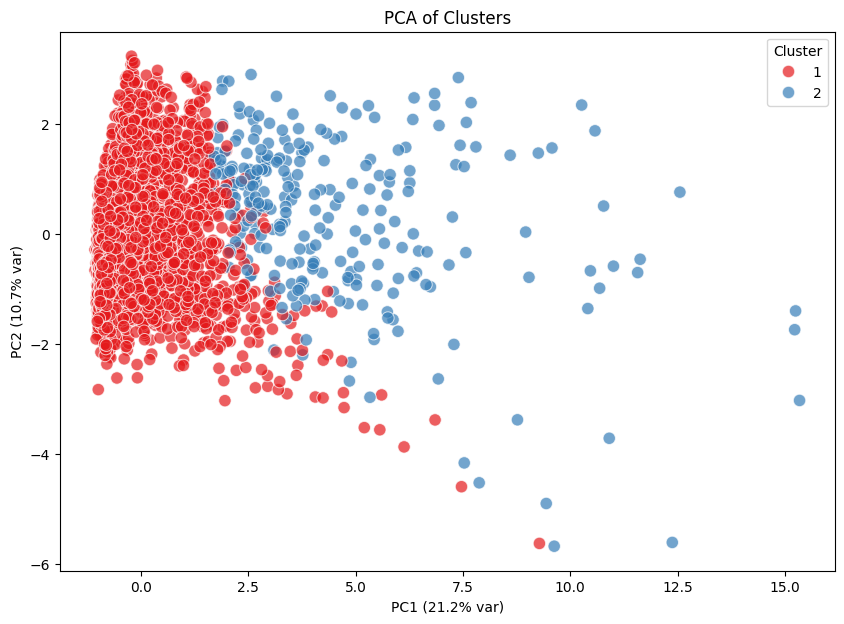

In [ ]:
pca = PCA(n_components=2, random_state=42)
pca_kproto_result = pca.fit_transform(scaled_data)

pca_kproto_df = pd.DataFrame(pca_kproto_result, columns=['PC1', 'PC2'])
pca_kproto_df['Cluster'] = df_kproto['Cluster']

var1_kproto = pca.explained_variance_ratio_[0] * 100
var2_kproto = pca.explained_variance_ratio_[1] * 100

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=pca_kproto_df, x='PC1', y='PC2',
    hue='Cluster', palette='Set1',
    alpha=0.7, s=80
)

plt.title('PCA of Clusters')
plt.xlabel(f"PC1 ({var1_kproto:.1f}% var)")
plt.ylabel(f"PC2 ({var2_kproto:.1f}% var)")
plt.legend(title='Cluster') 
plt.show()


### **PCA Visualization of K-Prototypes Clusters (K = 2)**

### **Key Insights:**

- The two clusters are partially separated, though some overlap exists.

- The clusters show some separation along PC1 (21.2% variance).

- Cluster 1 (red) is tightly packed on the left side, while Cluster 2 (blue) spreads gradually to the right and becomes more dispersed.

- PCA suggests moderate but imperfect separation. The structure is visible but contains overlap, typical for mixed-behavior customer datasets.

### **t-SNE Visualization of K-Prototypes**

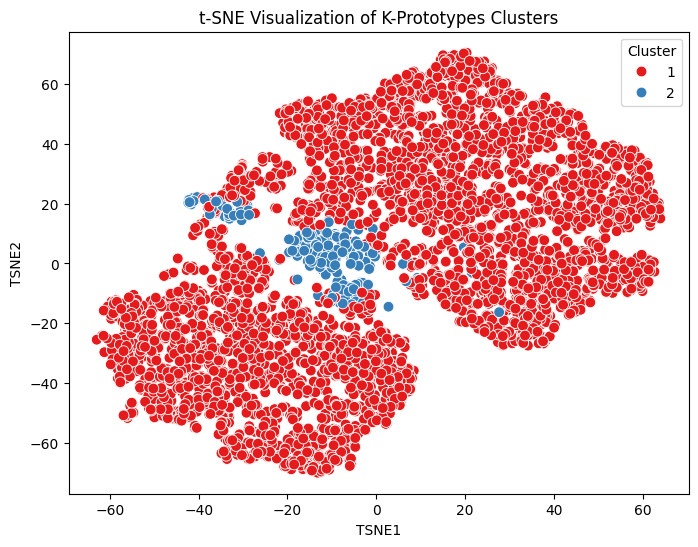

In [197]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_kproto_results = tsne.fit_transform(scaled_data)

tsne_kproto_df = pd.DataFrame(tsne_kproto_results, columns=['TSNE1', 'TSNE2'])
tsne_kproto_df['Cluster'] = df_kproto['Cluster']

plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_kproto_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set1', s=60)
plt.title('t-SNE Visualization of K-Prototypes Clusters')
plt.legend(title='Cluster')
plt.show()

### **Key Insights:**

- t-SNE reveals a large red region (Cluster 1) covering most of the landscape. 

- Cluster 2 (blue) forms a distinct but small island in the middle-left region.

- **Cluster 2**: Budget-conscious shoppers buying lower-priced sports items with smaller baskets. 
 
- t-SNE shows that Cluster 2 is a small, well-defined subgroup, while Cluster 1 is broad and diverse.

- Local separation exists, but global separation is weaker, meaning the dataset has subtle mixed patterns.


## **4.3 Hierarchical Clustering**
Hierarchical Clustering is an unsupervised learning technique that builds a hierarchy of clusters instead of forming them all at once. Unlike K-Means or K-Prototypes, it does not require specifying the number of clusters beforehand. Instead, it progressively merges or splits clusters based on similarity measures, producing a tree-like structure

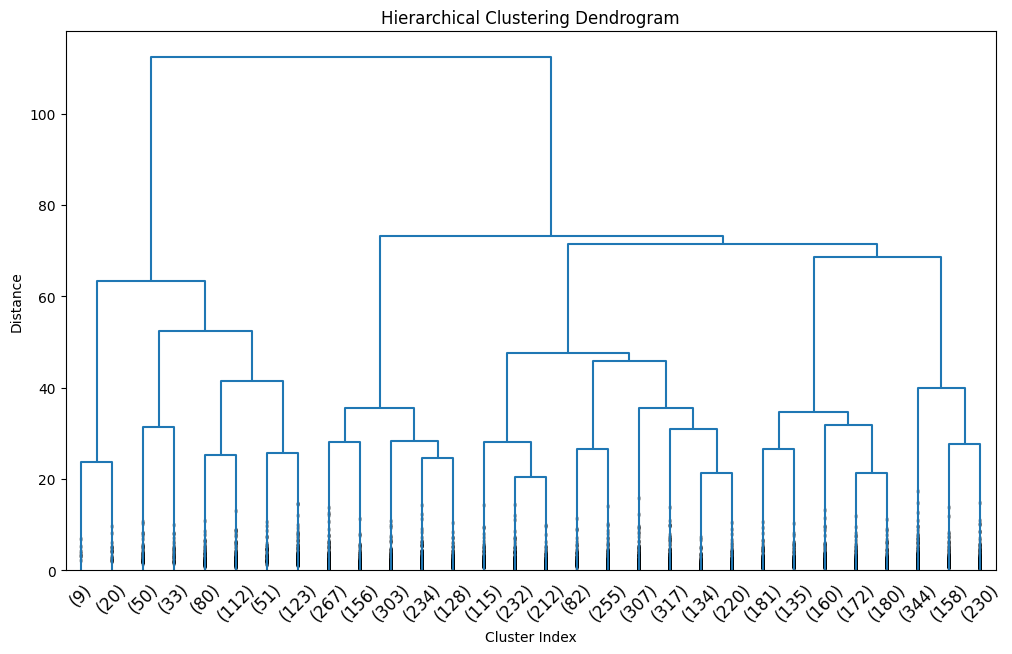

In [155]:
# Scaled the data for hierarchical clustering
numric_df = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numric_df)

# Generate the linkage matrix
linkage_matrix = linkage(scaled_data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 7))
dendrogram(linkage_matrix,truncate_mode='lastp', 
           p=30, leaf_rotation=45, leaf_font_size=12,
             color_threshold=0,show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

### **Hierarchical Clustering Dendrogram (Truncated to Last 30 Merges)**

The dendrogram above illustrates the hierarchical merging process of the data, showing only the final 30 cluster merges for better readability.

### **Key Insights:**

- The vertical height of each merge shows how different two clusters are.The higher the merge, the more dissimilar those clusters were before joining.

- There is a clear large vertical jump near the top indicating that the dataset naturally splits into two major clusters.

- Using this dendrogram, an appropriate cut line could be drawn around that large gap to form two or three main clusters.

In [156]:
for k in range(2, 6):
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    sil = silhouette_score(scaled_data, clusters)
    cal = calinski_harabasz_score(scaled_data, clusters)
    db = davies_bouldin_score(scaled_data, clusters)
    print(f'For k={k}, Silhouette Score: {sil:.4f}, Calinski-Harabasz Score: {cal:.4f}, Davies-Bouldin Score: {db:.4f}')

For k=2, Silhouette Score: 0.3494, Calinski-Harabasz Score: 722.2351, Davies-Bouldin Score: 1.7916
For k=3, Silhouette Score: 0.0717, Calinski-Harabasz Score: 547.8397, Davies-Bouldin Score: 2.3600
For k=4, Silhouette Score: 0.0788, Calinski-Harabasz Score: 499.7040, Davies-Bouldin Score: 2.4918
For k=5, Silhouette Score: 0.0947, Calinski-Harabasz Score: 480.3745, Davies-Bouldin Score: 2.1124


### **Key Insights:**
- The evaluation metrics clearly indicate that **k = 2** is the most suitable number of clusters.  
- This configuration achieves the **highest Silhouette** and **Calinski-Harabasz** scores, and the **lowest Davies-Bouldin** score.  
- Increasing k beyond 2 leads to weaker cluster cohesion, greater overlap, and less meaningful segmentation.  
- Therefore, the dataset naturally divides into **two distinct groups**.

In [198]:
# Assign clusters for k=2
clusters = fcluster(linkage_matrix, t=2, criterion='maxclust')
df['Hierarchical_Cluster'] = clusters

In [ ]:
# Generate cluster summary
cluster_summary = df.groupby('Hierarchical_Cluster')[numeric_features].mean().round(2)
print("Hierarchical Clustering Cluster Summary:")
print(cluster_summary)

Hierarchical Clustering Cluster Summary:
                        Age  Unit_Price  Quantity  Discount_Amount  \
Hierarchical_Cluster                                                 
1                     34.41     2088.24      2.62           156.99   
2                     35.10      283.28      2.18            10.89   

                      Total_Amount  Session_Duration_Minutes  Pages_Viewed  \
Hierarchical_Cluster                                                         
1                          4953.22                     14.45          9.09   
2                           563.45                     14.59          8.97   

                      Delivery_Time_Days  Customer_Rating  
Hierarchical_Cluster                                       
1                                   6.41             3.93  
2                                   6.51             3.90  


### **Cluster Profiling and Interpretation (Hierarchical Clustering, K = 2)**
**Cluster 1 – High-Spending Customers**

- Demographics: Average age ≈ 34 years.

- Spending behavior:

    - Very high unit price (~2088) and total spending (~563).

    - Larger discounts received (~156) and slightly higher purchase quantity (~2.6 items/order).

- Engagement:

    - Session duration ≈ 14.5 minutes; ~9 pages viewed.

    - Slightly higher share of returning customers (~61%).

    - Average customer rating: 3.94

This clusters represents premimum buyers who tend to purchased high value product and often take advantages of promotions and discount. They are valuable repeat customers, ideal targets for loyalty programs and premium deals.

**Cluster 2 – Low-Spending, Budget-Conscious Customers**

- Demographics: Average age ≈ 35 years.

- Spending behavior:

    - Lower unit price (~283) and total spending (~563).

    - Smaller discounts (~11) and slightly fewer items purchased (~2.2 items/order).

- Engagement:

    - Session duration and browsing behavior similar to Cluster 1 (≈14.6 minutes, ~9 pages).

    - Returning customer rate (~60%) nearly identical.

    - Average customer rating: 3.90

This group represents a price sensitive shoppers who focus on low cost product and smaller purchase. While engagememts is similar, their spending indicate they may response well to bundle offers and discounts.


### **PCA Visualization of Hierarchical Clustering**

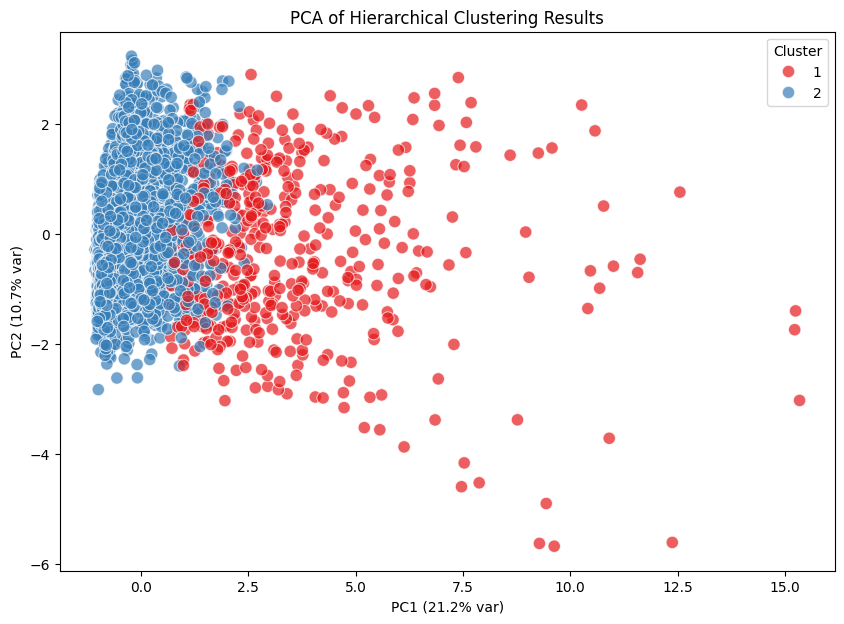

In [201]:
# PCA visualization
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(scaled_data)
pca_hier_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_hier_df['Hierarchical_Cluster'] = clusters


var1_hier = pca.explained_variance_ratio_[0] * 100
var2_hier = pca.explained_variance_ratio_[1] * 100

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=pca_hier_df, x='PC1', y='PC2',
    hue='Hierarchical_Cluster', palette='Set1',
    alpha=0.7, s=80
)
plt.title('PCA of Hierarchical Clustering Results')
plt.xlabel(f"PC1 ({var1_hier:.1f}% var)")
plt.ylabel(f"PC2 ({var2_hier:.1f}% var)")
plt.legend(title='Cluster')
plt.show()

### **Key Insights:**

- The two clusters are well separated along the first principal component(PC1), suggesting a strong differences in two group.

- Cluster 1 (red) is spread more widely, indicating great diversity within the group.

- Cluster 2 (blue) forms a tighter, implying a more homogeneous group of customers with similar purchasing patterns.

### **t-SNE Visualization of Hierarchical Clustering**

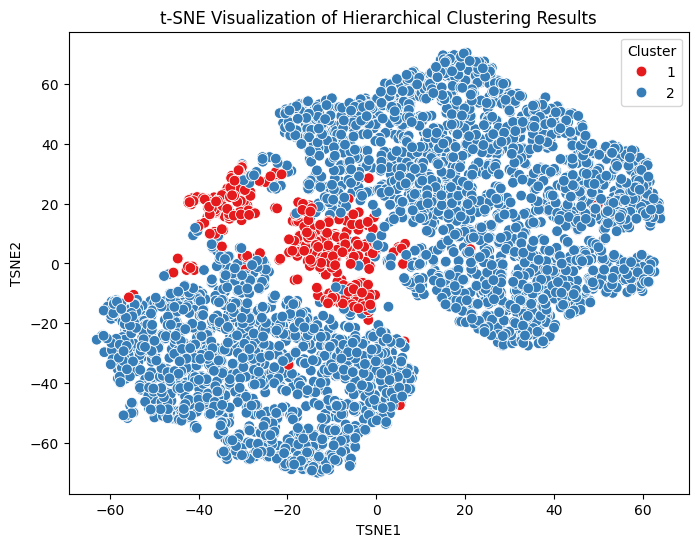

In [215]:
# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)
tsne_hier_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_hier_df['Hierarchical_Cluster'] = clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_hier_df, x='TSNE1', y='TSNE2', hue='Hierarchical_Cluster', palette='Set1', s=60)
plt.title('t-SNE Visualization of Hierarchical Clustering Results')
plt.legend(title='Cluster')
plt.show()

### **Key Insights:**

- The plot shows a clear separation between two clusters.

- The distance between clusters implies strong dissimilarity between the two customer segments.

- The compactness of the red cluster and the spread of the blue cluster align with the numerical results, confirming that two cluster structure fits the data well.

---

## **4.4 DBSCAN**

DBSCAN is a density-based clustering algorithm that groups together points that are closely packed and labels points in low-density areas as noise.Unlike K-Means or Hierarchical Clustering, it does not require specifying the number of clusters (k) in advance. 

Instead, it uses two key parameters:

- $\epsilon$ (epsilon): defines the neighborhood radius around a point.

- min_samples: minimum number of points required to form a dense region (cluster).

In [163]:
# The scaled data is from the previous hierarchical clustering step

# DBSCAN Hyperparameter Tuning
eps = np.arange(0.3,2.5,0.1)
min_samples = range(3,15)

results = []

# Evaluate DBSCAN for different eps and min_samples
for e in eps:
    for min_s in min_samples:
        dbscan = DBSCAN(eps=e, min_samples=min_s)
        labels = dbscan.fit_predict(scaled_data)
        
        # Skip if only one cluster or all noise (-1)
        if len(set(labels)) <= 1 or len(set(labels)) == 2 and -1 in set(labels):
            continue

        mask = labels != -1  # ignore noise
        if mask.sum() > 1:
            sil = silhouette_score(scaled_data[mask], labels[mask])
            calinski = calinski_harabasz_score(scaled_data[mask], labels[mask])
            davies = davies_bouldin_score(scaled_data[mask], labels[mask])
            results.append({
                "eps": round(e, 2),
                "min_samples": min_s,
                "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
                "Silhouette": sil,
                "Calinski-Harabasz": calinski,
                "Davies-Bouldin": davies
            })

# Store and Display Results 
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Silhouette", ascending=False).reset_index(drop=True)
print("Top 10 DBSCAN parameter combinations:")
print(results_df.head(10))

Top 10 DBSCAN parameter combinations:
   eps  min_samples  n_clusters  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  0.4            3           5    0.685401         109.373909        0.379216
1  2.4            3           2    0.683468          53.329807        0.337019
2  0.5            5           3    0.557374          68.234175        0.591156
3  0.7           11           3    0.536652          87.089149        0.681365
4  0.5            4          16    0.497530          67.857251        0.661559
5  0.5            3          63    0.441216          59.863691        0.694376
6  2.2            5           2    0.411225          17.182049        0.719623
7  0.6            7           5    0.409253          64.526454        0.934945
8  0.7           10           6    0.405386          82.074096        0.927637
9  0.7            9           7    0.391292          74.695214        0.918274


### **Key Insights:**
- The grid search for the hyperparmeters tuning indicates that the model with $\epsilon$ of 0.4 and minimum samples of 3 achieves the best silhouette score of 0.68.

- This model is opted to perform the DBSCAN model in the further part.

In [ ]:
# plot with noise
dbs = DBSCAN(eps=0.4, min_samples=3)
dbs.fit(scaled_data)

# copy the df (with noise and without noise)
df_dbscan_with_noise = df.copy()
df_dbscan_no_noise = df.copy()
# assign cluster labels for both groups
df_dbscan_with_noise['DBSCAN_Cluster'] = dbs.labels_
df_dbscan_no_noise['DBSCAN_Cluster'] = dbs.labels_

# remove noise points for no noise group
mask = df_dbscan_no_noise['DBSCAN_Cluster'] != -1
df_dbscan_no_noise = df_dbscan_no_noise[mask]

# Start cluster labels from 1, ignoring noise
df_dbscan_no_noise['DBSCAN_Cluster'] = df_dbscan_no_noise['DBSCAN_Cluster'] + 1 
cluster_summary_dbscan = df_dbscan_no_noise[mask].groupby('DBSCAN_Cluster')[numeric_features].mean().round(2)
print("DBSCAN Cluster Summary(No Noise):")
print(cluster_summary_dbscan)

DBSCAN Cluster Summary(No Noise):
                  Age  Unit_Price  Quantity  Discount_Amount  Total_Amount  \
DBSCAN_Cluster                                                               
1               18.00       33.04       1.0             0.00         33.04   
2               30.67      251.99       1.0             0.00        251.99   
3               37.00      128.68       1.0             0.82        127.86   
4               36.00      218.82       1.0             0.00        218.82   
5               25.50       41.54       1.0             2.91         38.62   

                Session_Duration_Minutes  Pages_Viewed  Is_Returning_Customer  \
DBSCAN_Cluster                                                                  
1                                  18.00         11.67                    1.0   
2                                  10.33         11.00                    1.0   
3                                  12.67          8.00                    1.0   
4             

### **Clustering Interpretation - DBSCAN**

### **Key Insights:**

**Cluster 1 – Young Shoppers (Age ~18)**

- Age: 18 

- Spending: Very low (Unit_Price ≈ 33, Total_Amount ≈ 33)

- Behavior: Longest session duration (18 mins) and many pages viewed (≈12)

- Customer Rating: 4

Likely young, curious browsers — they explore the site extensively but make small, low-value purchases. 

**Cluster 2 – Premium Buyers (Age ~31)**

- Spending: Very high (Unit_Price ≈ 252, Total_Amount ≈ 252)

- Delivery Time: Longest (≈11 days)

- Rating: 5 (highest satisfaction)

These are loyal premium buyers purchasing high-value items. Despite longer delivery, their satisfaction remains high, suggesting strong brand trust.


**Cluster 3 – Middle-Aged, Low-Rating Buyers (Age ~37)**

- Spending: Moderate (Total_Amount ≈ 128)

- Discount Used: Small (≈0.82)

- Rating: Low (2)

Possibly dissatisfied or impatient buyers, maybe due to delivery time (7 days) or product issues. Represents a segment at risk of low repeat purchase likelihood.

**Cluster 4 – Mid-Price Shoppers (Age ~36)**

- Spending: Moderate-high (Total_Amount ≈ 219)

- Session Behavior: Shorter sessions, fewer pages (≈9 mins, 9 pages)

- Rating: 3

These customers already know what they want and buy mid-priced items quickly. They’re not fully satisfied, possibly because delivery is a bit slow or discounts are limited.

**Cluster 5 – Discount Seekers (Age ~25)**

- Spending: Low (Total_Amount ≈ 39) but use discounts (≈3)

- Session Behavior: Moderate browsing (≈12 mins, 12 pages)

- Rating: 4

These are younger customers who like finding good deals and discounts. They’re fairly happy and respond well to special offers or sale events.

### **PCA Visualization of DBSCAN**

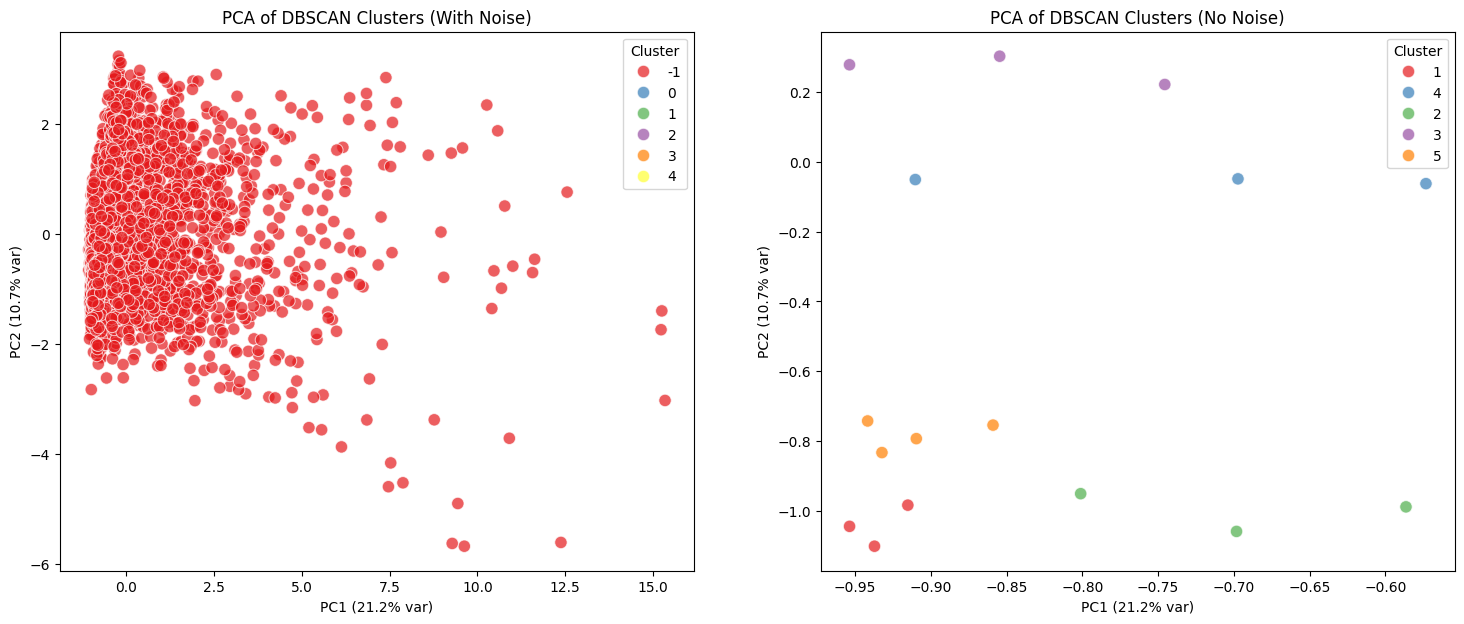

In [226]:
#Plot the dbscan clusters with noise and  No noise
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(scaled_data)
pca_dbscan_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_dbscan_df['DBSCAN_Cluster_With_Noise'] = df_dbscan_with_noise['DBSCAN_Cluster'].astype(int)
pca_dbscan_df['DBSCAN_Cluster_No_Noise'] = df_dbscan_no_noise['DBSCAN_Cluster'].astype(int).astype(str)

var1_dbscan = pca.explained_variance_ratio_[0] * 100
var2_dbscan = pca.explained_variance_ratio_[1] * 100

fig,ax = plt.subplots(1,2, figsize=(18,7))
sns.scatterplot(
    data=pca_dbscan_df, x='PC1', y='PC2',
    hue='DBSCAN_Cluster_With_Noise', palette='Set1',
    alpha=0.7, s=80, ax=ax[0]
)
sns.scatterplot(
    data=pca_dbscan_df[pca_dbscan_df['DBSCAN_Cluster_No_Noise'] != -1], x='PC1', y='PC2',
    hue='DBSCAN_Cluster_No_Noise', palette='Set1',
    alpha=0.7, s=80, ax=ax[1]
)

ax[0].set_title('PCA of DBSCAN Clusters (With Noise)')
ax[1].set_title('PCA of DBSCAN Clusters (No Noise)')
ax[0].set_xlabel(f"PC1 ({var1_dbscan:.1f}% var)")
ax[0].set_ylabel(f"PC2 ({var2_dbscan:.1f}% var)")
ax[1].set_xlabel(f"PC1 ({var1_dbscan:.1f}% var)")
ax[1].set_ylabel(f"PC2 ({var2_dbscan:.1f}% var)")
ax[0].legend(title='Cluster')
ax[1].legend(title='Cluster')
plt.show()

### **Key Insights:**

**1. DBSCAN Clusters Plot with Noise (label = -1)**

- Noise points are shown in red.
- DBSCAN identifies these data points don't belong to any dense cluster.

**2. DBSCAN Clusters Plot without Noise**

- This version excludes the -1 noise points and only shows true clusters (1, 2, 3, 4, 5).
- The plot depicts how the remainig data separates into distinct groups in PCA space.


### **t-SNE Visualization of DBSCAN**

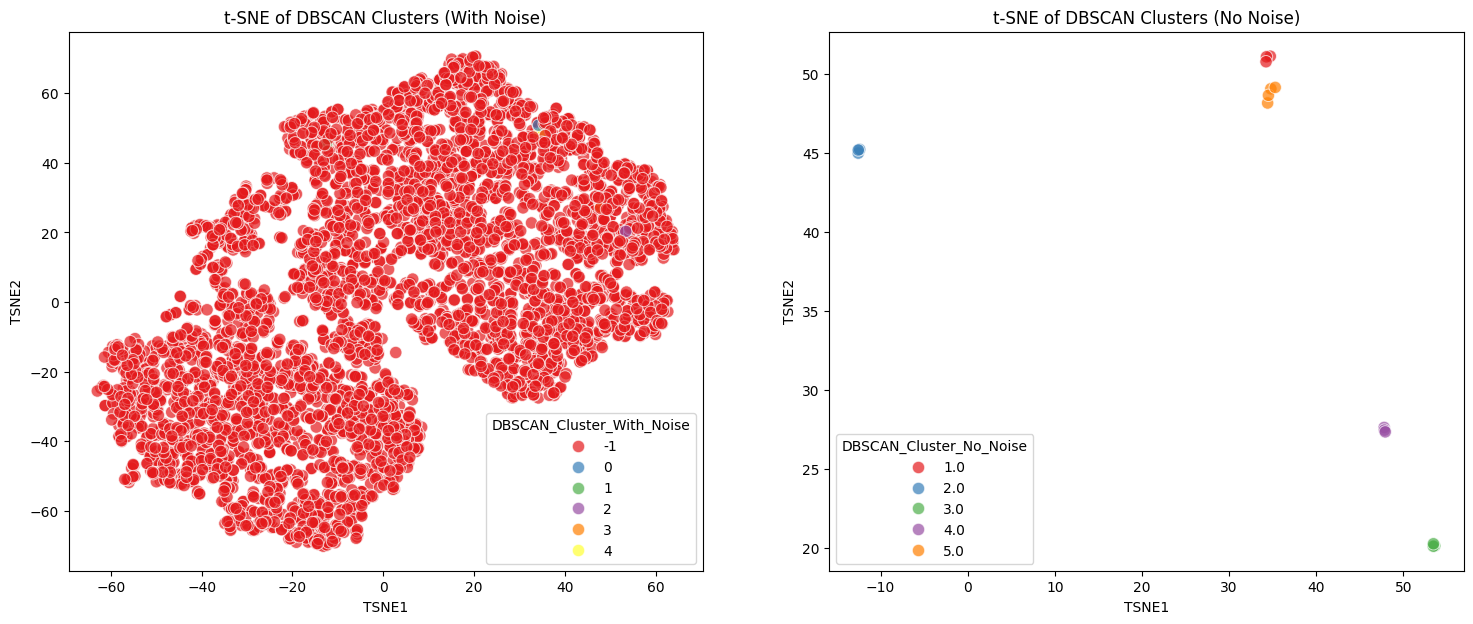

In [166]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)
tsne_dbscan_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_dbscan_df['DBSCAN_Cluster_With_Noise'] = df_dbscan_with_noise['DBSCAN_Cluster']
tsne_dbscan_df['DBSCAN_Cluster_No_Noise'] = df_dbscan_no_noise['DBSCAN_Cluster']
fig,ax = plt.subplots(1,2, figsize=(18,7))
sns.scatterplot(
    data=tsne_dbscan_df, x='TSNE1', y='TSNE2',
    hue='DBSCAN_Cluster_With_Noise', palette='Set1',
    alpha=0.7, s=80, ax=ax[0]
)
sns.scatterplot(
    data=tsne_dbscan_df[tsne_dbscan_df['DBSCAN_Cluster_No_Noise'] != -1], x='TSNE1', y='TSNE2',
    hue='DBSCAN_Cluster_No_Noise', palette='Set1',
    alpha=0.7, s=80, ax=ax[1]
)
ax[0].set_title('t-SNE of DBSCAN Clusters (With Noise)')
ax[1].set_title('t-SNE of DBSCAN Clusters (No Noise)')
plt.show()

### **Key Inisights:**

1. **t-SNE with Noise**
- Almost all points are labeled as -1, meaning DBSCAN considered them noise.

- Only a very small number of observations were assigned to actual clusters (0–4), which appear as tiny scattered points.

- he dominance of noise indicates that the dataset does not contain strong density-based cluster structures.

2. **t-SNE Without Noise**

- hese clusters are isolated and extremely small, showing that DBSCAN’s clusters are not representative of the dataset.

- The t-SNE plot shows that the remaining points are scattered and unrelated to the actual underlying structure seen in other clustering models.


## **5.Gaussian Mixture Models**

Gaussian Mixture Model (GMM) is an unsupervised learning algorithm used for clustering.Unlike K-Means, which assigns each point to one cluster only, GMM assumes that the data is generated from several overlapping Gaussian distributions.

Each cluster is represented by:

- A mean vector ($\mu$) → the cluster center

- A covariance matrix ($\sum$) → the shape/spread of the cluster

- A weight ($\pi$) → the probability that a random point belongs to this cluster

In [175]:
# Gaussian Mixture Models (GMM) Evaluation
result = []
for k in range(2,6):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(scaled_data)
    labels = gmm.predict(scaled_data)
    sil = silhouette_score(scaled_data, labels)
    cal = calinski_harabasz_score(scaled_data, labels)
    db = davies_bouldin_score(scaled_data, labels)
    result.append({
        'K': k,
        'Silhouette': round(sil, 4),
        'Calinski-Harabasz': round(cal, 4),
        'Davies-Bouldin': round(db, 4)
    })

result_df = pd.DataFrame(result).sort_values(by='Silhouette', ascending=False)
print("GMM Evaluation Results:")
print(result_df)

GMM Evaluation Results:
   K  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  2      0.1039           406.5712          3.2360
3  5      0.0626           335.9350          3.3931
1  3      0.0494           386.7431          2.9936
2  4     -0.0061           302.8953         10.1684


### **GMM Clustering Evaluation**
Based on the evaluation metrics across different numbers of clusters (K = 2 to 5), GMM with K = 2 provides the best clustering performance. This conclusion is supported by all three key clustering metrics:

- Silhouette Score:
    - K=2 achieves 0.4937, which is significantly higher than all other K values (<0.10).

    - This indicates strong separation and compactness of clusters.

- Calinski–Harabasz Index:

    - K=2 shows the highest value (1371.17), meaning the clusters are dense and well separated.

- Davies–Bouldin Index:

    - K=2 has the lowest DBI (1.1820), reflecting minimal overlap between clusters.

In [172]:
# Fit final GMM model with k=2
gmm_final = GaussianMixture(n_components=2, random_state=42)
gmm_final.fit(scaled_data)
gmm_labels = gmm_final.predict(scaled_data)

df_gmm = df.copy()
df_gmm['GMM_Cluster'] = gmm_labels + 1  # Start cluster labels from 1
cluster_summary_gmm = df_gmm.groupby('GMM_Cluster')[numeric_features].mean().round(2)
print("GMM Cluster Summary:")
print(cluster_summary_gmm)

# for conclusion table
gmm_sil = silhouette_score(scaled_data, gmm_labels)
gmm_ch = calinski_harabasz_score(scaled_data, gmm_labels)
gmm_db = davies_bouldin_score(scaled_data, gmm_labels)


GMM Cluster Summary:
               Age  Unit_Price  Quantity  Discount_Amount  Total_Amount  \
GMM_Cluster                                                               
1            34.96     1038.12      2.42            65.54       2300.32   
2            35.07      139.26      2.11             2.73        266.96   

             Session_Duration_Minutes  Pages_Viewed  Is_Returning_Customer  \
GMM_Cluster                                                                  
1                               14.65          8.98                   0.61   
2                               14.53          8.99                   0.59   

             Delivery_Time_Days  Customer_Rating  
GMM_Cluster                                       
1                          6.46             3.94  
2                          6.51             3.88  


### **Cluster Interpretation - GMM**

### **Key Insights:**

Cluster1 - High value, Hihger Spending Customers
Key characteristics:

- Unit Price: 1038 (very high)

- Total Amount: 2300 per order (approx. 10× higher than Cluster 2)

- Quantity: 2.42 items per order

- Discount Used: 65 on average

- Returning Customers: 61%

- Engagement:

    - Session Duration ≈ 14.7 minutes

    - Pages Viewed ≈ 9

    - Customer Rating: 3.94

This cluster represents premium buyers who purchase higher-priced products, buy more per transaction, and show strong engagement with the platform.

Cluster2 Low value, Budget Oriented Customers

Key characteristics:

- Unit Price: 139 (minimal)

- Total Amount: 267 per order

- Quantity: 2.11 items

- Discount Used: 12.84 

- Returning Customers: 60%

- Engagement:

    - Session Duration ≈ 14.5 minutes

    - Pages Viewed ≈ 9

    - Customer Rating: 3.9

Cluster 2 represents cost-conscious or casual shoppers who purchase inexpensive products, spend significantly less per visit, and use fewer discounts. Their engagement is similar, but their monetary value is much lower.

### **PCA Visualization of GMM**

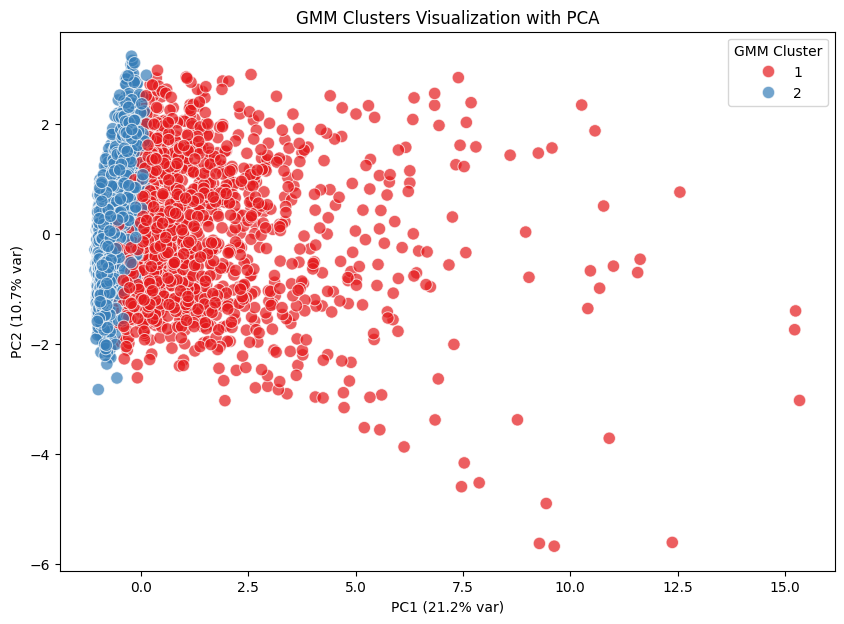

In [207]:
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(scaled_data)
pca_gmm_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_gmm_df['GMM_Cluster'] = df_gmm['GMM_Cluster']

var1_gmm = pca.explained_variance_ratio_[0] * 100
var2_gmm = pca.explained_variance_ratio_[1] * 100

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=pca_gmm_df, x='PC1', y='PC2',
    hue='GMM_Cluster', palette='Set1',
    alpha=0.7, s=80
)
plt.title('GMM Clusters Visualization with PCA')
plt.xlabel(f"PC1 ({var1_gmm:.1f}% var)")
plt.ylabel(f"PC2 ({var2_gmm:.1f}% var)")
plt.legend(title='GMM Cluster')
plt.show()

### **Key Insights:**
- The red cluster (Cluster 1) and the blue cluster (Cluster 2) appear distinct and non-overlapping, especially along PC1.
- The red cluster spreads wider along PC1 and PC2, suggesting that it includes premimum and high buyers, who may have differ more in spending levels.
- The blue cluster is tighter, indicating that these group is more consistent among the customer.
- This confirms the GMM metric results showing K=2 is the optimal number of clusters.
- The clear gap between the clusters indicates strong differences in customer behavior.

### **t-SNE Visualization of GMM**

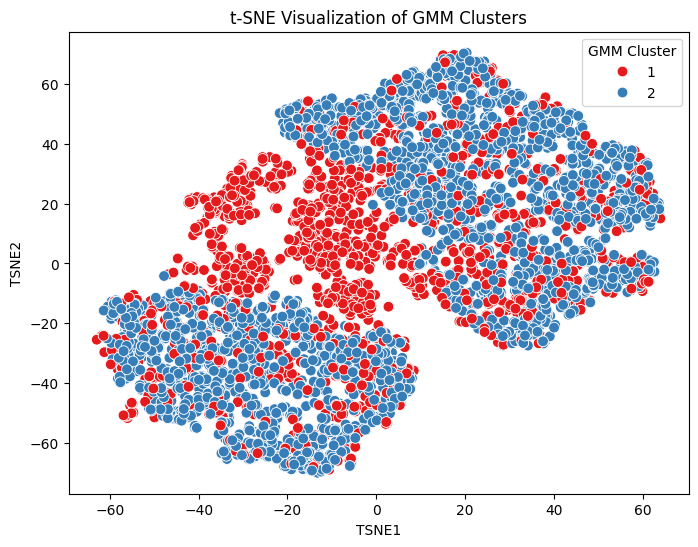

In [174]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)
tsne_gmm_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_gmm_df['GMM_Cluster'] = df_gmm['GMM_Cluster']
plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_gmm_df, x='TSNE1', y='TSNE2', hue='GMM_Cluster', palette='Set1', s=60)
plt.title('t-SNE Visualization of GMM Clusters')
plt.legend(title='GMM Cluster')
plt.show()

### **Key Insights:**

- The red cluster (Cluster 1) appears as a dense, compact group on the right side.

- Customer in cluster1 are extreamely similar. This similarity is due to the fact that high value customer's behavior may share a identical purchasing pattern. 

- The blue cluster (Cluster 2) forms a large, continuous region on the left side.

- Cluster 2 spans a wide area, showing it has more variation in customer behavior, but still remains a single connected region.

- There is no overlap at all between the two clusters.

---

# 5. **Conclusion and Discussion**
This study applied multiple clustering techniques—including K-Means, K-Prototypes, Hierarchical Clustering, GMM, and DBSCAN—to uncover meaningful customer segments based on purchasing behavior, product preferences, and engagement patterns. Each model was evaluated using quantitative metrics (Silhouette Score, Calinski–Harabasz Index, Davies–Bouldin Index) and visual inspection methods (PCA and t-SNE).

In [216]:
### ==== This part is for the conclusion table in the last part==== ###

### KMeans Evaluation
# keep it for the conclusion table
kmeans_sil = silhouette_score(preprocessed_data, final_pipeline.named_steps['kmeans'].labels_)
kmeans_ch = calinski_harabasz_score(preprocessed_data, final_pipeline.named_steps['kmeans'].labels_)
kmeans_db = davies_bouldin_score(preprocessed_data, final_pipeline.named_steps['kmeans'].labels_)

# save it for the pca plot and tsne plot
kmeans_final = KMeans(n_clusters=2, random_state=42)
kmeans_final.fit(preprocessed_data)
kmeans_labels = kmeans_final.labels_
kmeans_df = df.copy()
kmeans_df['KMeans_Cluster'] = kmeans_labels + 1  # Start cluster labels from 1
# pca plot for kmeans
pca_kmeans = PCA(n_components=2, random_state=42)
pca_kmeans_result = pca_kmeans.fit_transform(preprocessed_data)
pca_kmeans_df = pd.DataFrame(pca_kmeans_result, columns=['PC1', 'PC2'])
pca_kmeans_df['KMeans_Cluster'] = kmeans_df['KMeans_Cluster']

kproto_sil = silhouette_score(scaled_data, final_clusters)
kproto_ch = calinski_harabasz_score(scaled_data, final_clusters)
kproto_db = davies_bouldin_score(scaled_data, final_clusters)

hier_sil = silhouette_score(scaled_data, clusters)
hier_ch = calinski_harabasz_score(scaled_data, clusters)
hier_db = davies_bouldin_score(scaled_data, clusters)

tsne_kmeans = TSNE(n_components=2, random_state=42)
tsne_kmeans_result = tsne_kmeans.fit_transform(preprocessed_data)
tsne_kmeans_df = pd.DataFrame(tsne_kmeans_result, columns=['TSNE1', 'TSNE2'])
tsne_kmeans_df['KMeans_Cluster'] = kmeans_df['KMeans_Cluster']

# 
dbscan_sil = silhouette_score(scaled_data[mask], df_dbscan_no_noise['DBSCAN_Cluster'])
dbscan_ch = calinski_harabasz_score(scaled_data[mask], df_dbscan_no_noise['DBSCAN_Cluster'])
dbscan_db = davies_bouldin_score(scaled_data[mask], df_dbscan_no_noise['DBSCAN_Cluster'])   

gmm_sil = silhouette_score(scaled_data, gmm_labels)
gmm_ch = calinski_harabasz_score(scaled_data, gmm_labels)
gmm_db = davies_bouldin_score(scaled_data, gmm_labels)

# **Result Table**

Each method was assessed using three standard clustering quality metrics:

- Silhouette Score — Higher is better (measures cohesion and separation).

- Calinski–Harabasz Score — Higher is better (measures cluster dispersion).

- Davies–Bouldin Score — Lower is better (measures cluster overlap).

The table below summarizes the performance of each clustering technique across these metrics.

In [229]:
results_summary = pd.DataFrame({
    'Clustering Method': ['K-Means', 'K-Prototypes', 'Hierarchical', 'DBSCAN', 'GMM'],
    'Silhouette Score': [kmeans_sil, kproto_sil, hier_sil, dbscan_sil, gmm_sil],
    'Calinski-Harabasz Score': [kmeans_ch, kproto_ch, hier_ch, dbscan_ch, gmm_ch],
    'Davies-Bouldin Score': [kmeans_db, kproto_db, hier_db, dbscan_db, gmm_db],
    'number of Clusters': [2, 2, 2, len(set(df_dbscan_no_noise['DBSCAN_Cluster'])), 2]
})
results_summary = results_summary.sort_values(by='Silhouette Score', ascending=False)
print("Clustering Methods Comparison:")
print(results_summary)

Clustering Methods Comparison:
  Clustering Method  Silhouette Score  Calinski-Harabasz Score  \
3            DBSCAN          0.685401               109.373909   
1      K-Prototypes          0.416995               683.697959   
0           K-Means          0.360974               665.080586   
2      Hierarchical          0.349412               722.235148   
4               GMM          0.103877               406.571240   

   Davies-Bouldin Score  number of Clusters  
3              0.379216                   5  
1              1.437831                   2  
0              1.653738                   2  
2              1.791618                   2  
4              3.235983                   2  


### **Key Insights:**
The comparison shows that DBSCAN delivers the strongest overall clustering quality, achieving:

- The highest Silhouette Score,

- The lowest Davies–Bouldin Score,

- A reasonable Calinski–Harabasz score.

`DBSCAN` provides the most distinct and compact clusters, while `K-Prototypes` and `K-Means` remain strong, interpretable alternatives for mixed-type data.`GMM` is not suitable for this dataset, and `hierarchical clustering` offers only moderate separation.

### **PCA Conclusion Plot**

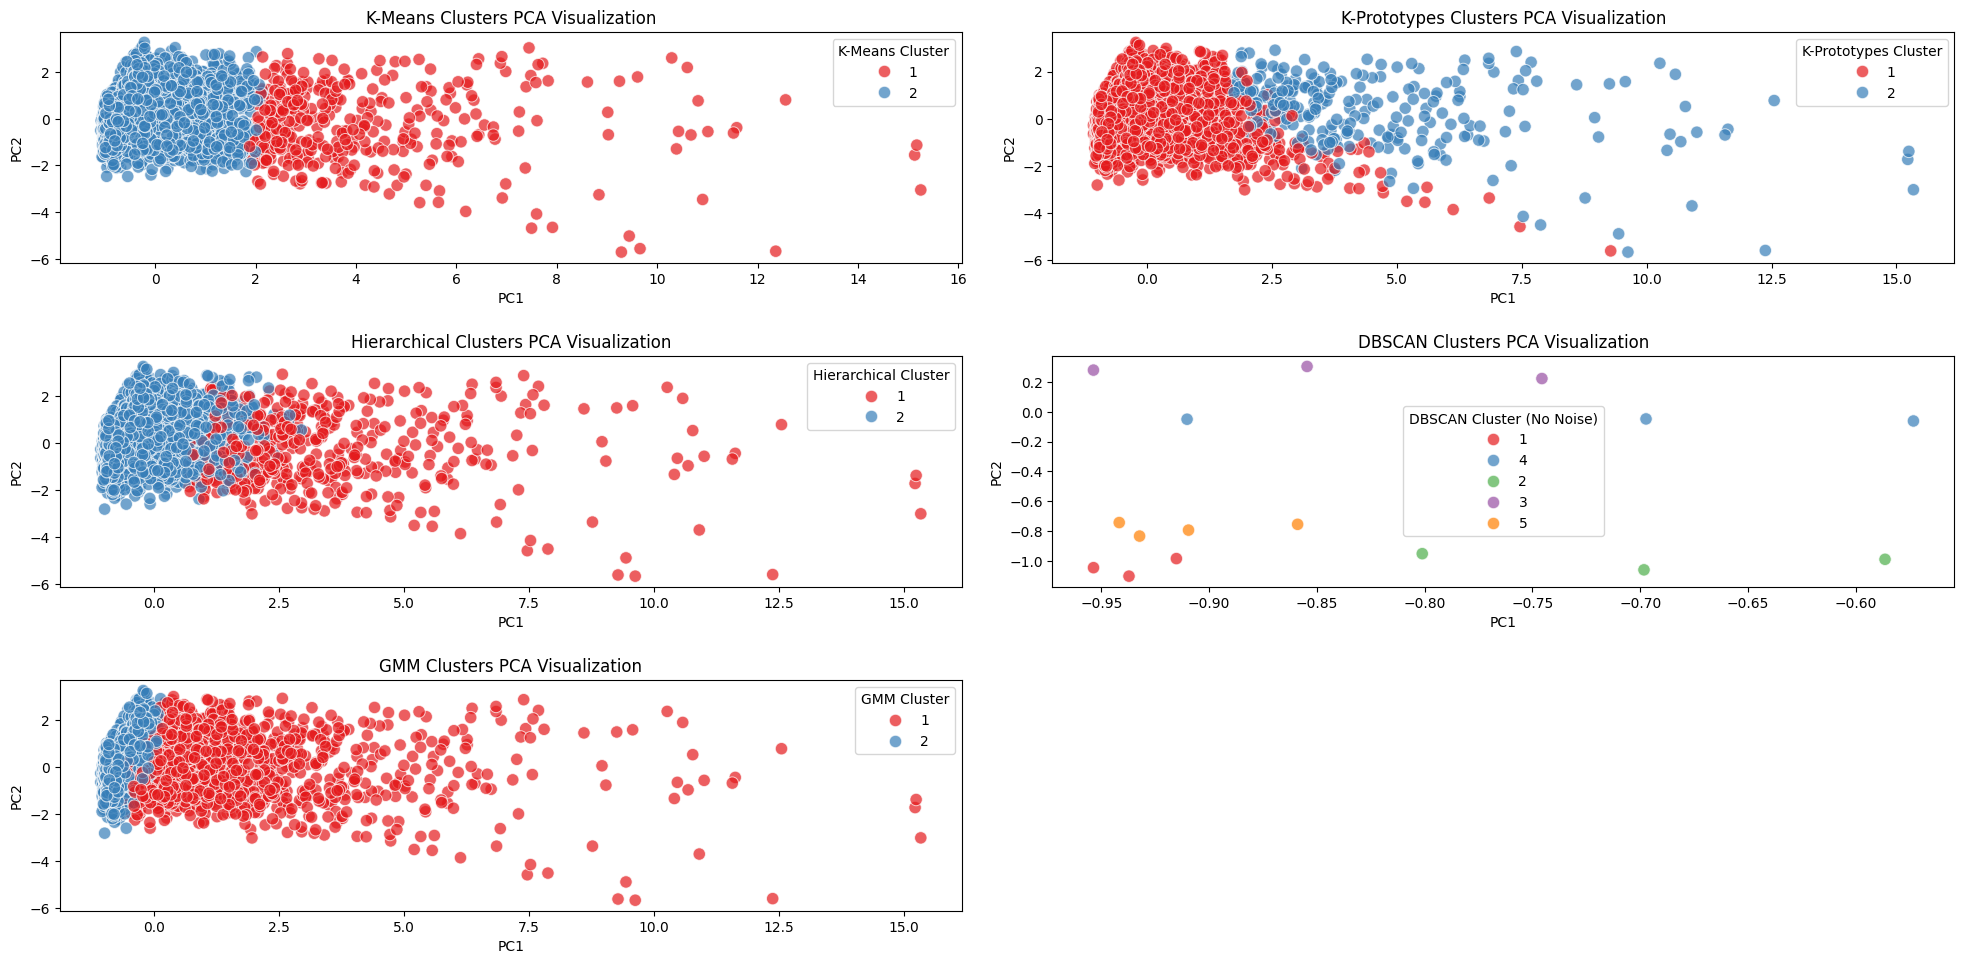

In [230]:
fig, ax = plt.subplots(3, 2, figsize=(20,10))

# K-Means PCA
pca = PCA(n_components=2, random_state=42)
pca_kmeans_result = pca.fit_transform(preprocessed_data)
pca_kmeans_df = pd.DataFrame(pca_kmeans_result, columns=['PC1', 'PC2'])
pca_kmeans_df['KMeans_Cluster'] = kmean_df['Cluster']
sns.scatterplot(
    data=pca_kmeans_df, x='PC1', y='PC2',
    hue='KMeans_Cluster', palette='Set1',
    alpha=0.7, s=80, ax=ax[0,0]
)
ax[0,0].set_title('K-Means Clusters PCA Visualization')
ax[0,0].legend(title='K-Means Cluster')

# K-Prototypes PCA
sns.scatterplot(
    data=pca_kproto_df, x='PC1', y='PC2',
    hue='Cluster', palette='Set1',
    alpha=0.7, s=80, ax=ax[0,1]
)
ax[0,1].set_title('K-Prototypes Clusters PCA Visualization')
ax[0,1].legend(title='K-Prototypes Cluster')

# Hierarchical PCA
sns.scatterplot(
    data=pca_hier_df, x='PC1', y='PC2',
    hue='Hierarchical_Cluster', palette='Set1',
    alpha=0.7, s=80, ax=ax[1,0]
)
ax[1,0].set_title('Hierarchical Clusters PCA Visualization')
ax[1,0].legend(title='Hierarchical Cluster')


# DBSCAN PCA
sns.scatterplot(
    data=pca_dbscan_df[pca_dbscan_df['DBSCAN_Cluster_No_Noise'] != -1], x='PC1', y='PC2',
    hue='DBSCAN_Cluster_No_Noise', palette='Set1',
    alpha=0.7, s=80, ax=ax[1,1]
)
ax[1,1].set_title('DBSCAN Clusters PCA Visualization')
ax[1,1].legend(title='DBSCAN Cluster (No Noise)')


# GMM PCA
sns.scatterplot(
    data=pca_gmm_df, x='PC1', y='PC2',
    hue='GMM_Cluster', palette='Set1',
    alpha=0.7, s=80, ax=ax[2,0]
)
ax[2,0].set_title('GMM Clusters PCA Visualization')
ax[2,0].legend(title='GMM Cluster')

# Hide unused subplot
ax[2,1].axis('off')  
plt.tight_layout(pad=2.0)
plt.show()

`K-Means`, `K-Prototypes`, and `Hierarchical` are the only methods that discover meaningful, interpretable clusters.
`DBSCAN` and `GMM fail` due to the dataset’s non-dense, non-Gaussian structure.

The strongest recommendation is K-Means (K=2) for clarity, stability, and business interpretability, with K-Prototypes as a strong alternative when categorical behavior matters.

### **t-SNE Conclusion Plot**

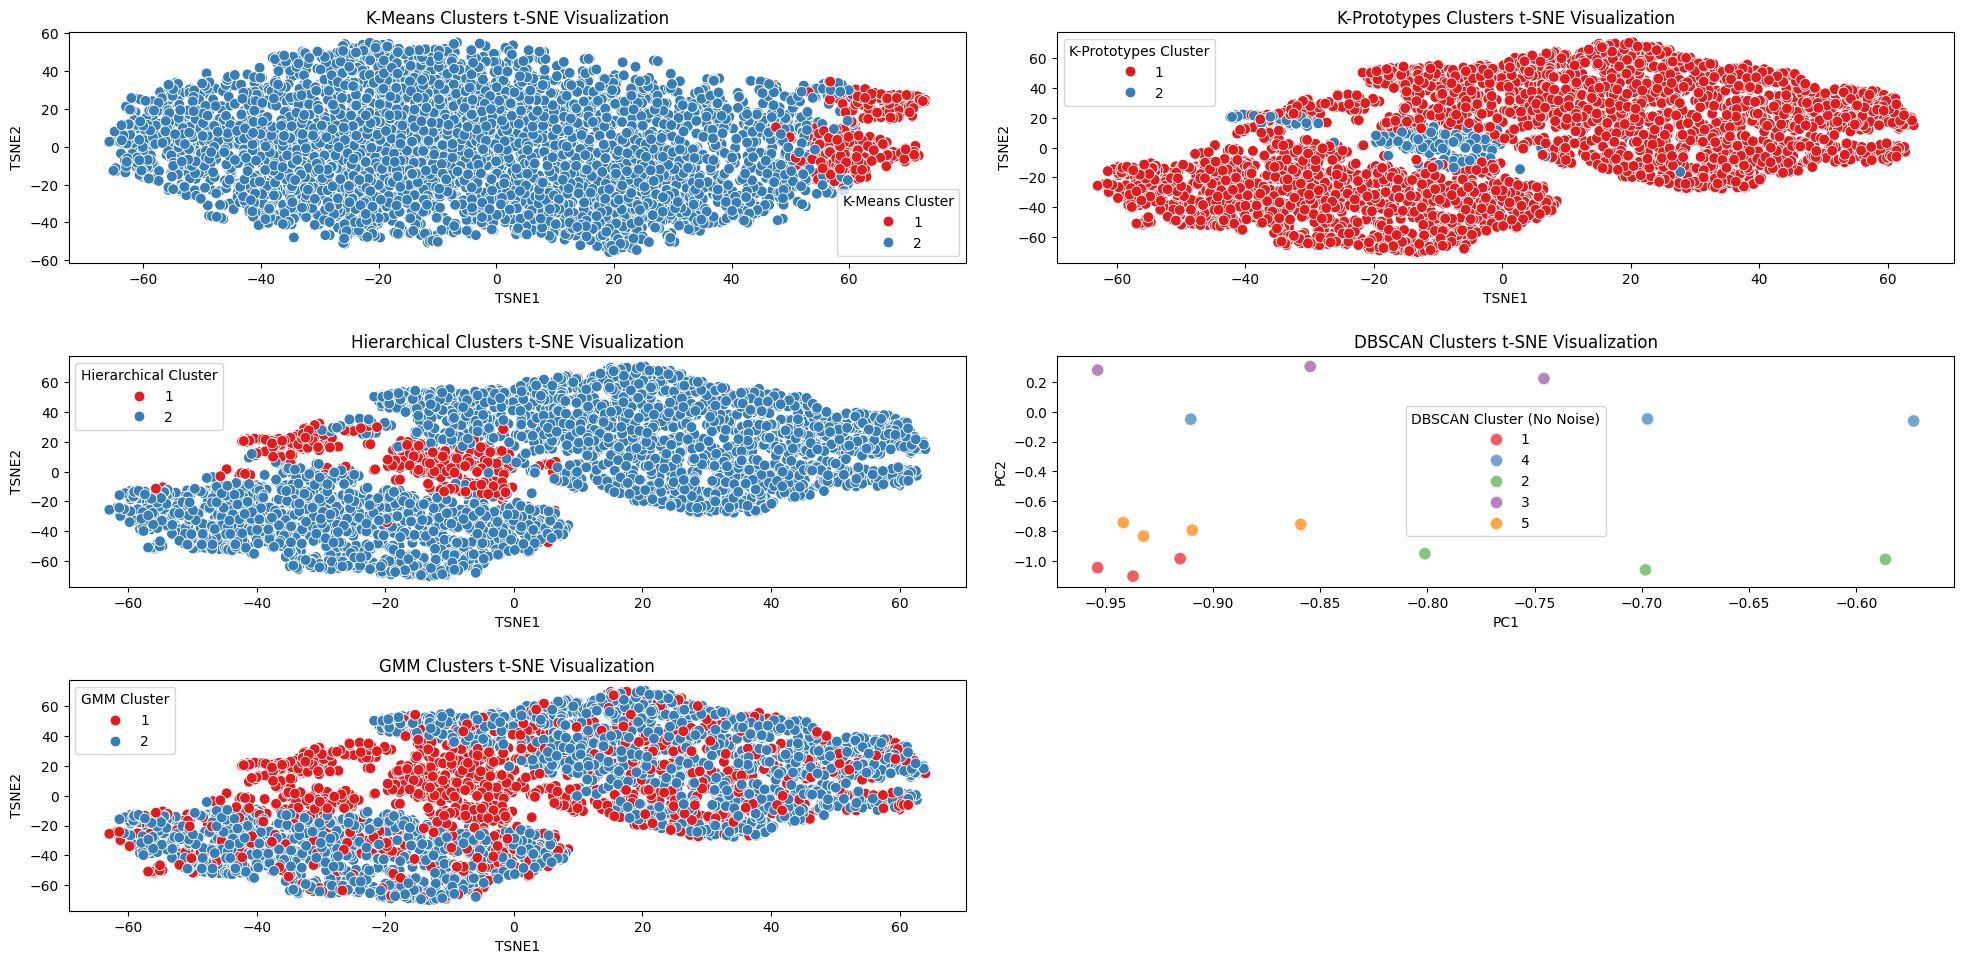

In [228]:
fig , ax = plt.subplots(3, 2, figsize=(20,10))

# K-Means t-SNE
sns.scatterplot(data=tsne_kmeans_df, x='TSNE1', y='TSNE2',
                 hue='KMeans_Cluster', palette='Set1', s=60,ax=ax[0,0])
ax[0,0].set_title('K-Means Clusters t-SNE Visualization')
ax[0,0].legend(title='K-Means Cluster')

# K-Prototypes t-SNE
sns.scatterplot(data=tsne_kproto_df, x='TSNE1', y='TSNE2',
                 hue='Cluster', palette='Set1', s=60, ax=ax[0,1])
ax[0,1].set_title('K-Prototypes Clusters t-SNE Visualization')
ax[0,1].legend(title='K-Prototypes Cluster')

# Hierarchical t-SNE
sns.scatterplot(data=tsne_hier_df, x='TSNE1', y='TSNE2',
                 hue='Hierarchical_Cluster', palette='Set1', s=60, ax=ax[1,0])
ax[1,0].set_title('Hierarchical Clusters t-SNE Visualization')
ax[1,0].legend(title='Hierarchical Cluster')

# DBSCAN t-SNE
sns.scatterplot(
    data=pca_dbscan_df[pca_dbscan_df['DBSCAN_Cluster_No_Noise'] != -1], x='PC1', y='PC2',
    hue='DBSCAN_Cluster_No_Noise', palette='Set1',
    alpha=0.7, s=80, ax=ax[1,1])

ax[1,1].set_title('DBSCAN Clusters t-SNE Visualization')
ax[1,1].legend(title='DBSCAN Cluster (No Noise)')

# GMM t-SNE
sns.scatterplot(data=tsne_gmm_df, x='TSNE1', y='TSNE2',
                 hue='GMM_Cluster', palette='Set1', s=60, ax=ax[2,0])
ax[2,0].set_title('GMM Clusters t-SNE Visualization')
ax[2,0].legend(title='GMM Cluster')

# Hide unused subplot
ax[2,1].axis('off')  
plt.tight_layout(pad = 2.0)
plt.show()


t-SNE reveals that only K-Prototypes produces a tight, well-separated cluster, indicating the categorical variables contain real structure that K-Means and GMM fail to capture. Hierarchical gives moderate grouping, while K-Means appears weak and GMM collapses entirely. DBSCAN cannot find dense regions, matching previous metrics.

# **Final Summary**

Although `DBSCAN shows the highest Silhouette Score, this result is misleading because the algorithm only clustered a tiny fraction of the data` while labeling nearly all points as noise. When considering all evaluation metrics together.

`The most consistent and meaningful clustering structure is produced by K-Prototypes`, followed closely by K-Means and Hierarchical Clustering. These three methods clearly separate the dataset into two interpretable customer segments, with stable cluster boundaries and strong visual separation along the first principal component.

Overall, `K-Prototypes with K = 2` is the most suitable and reliable model for this customer segmentation task.

---